# 生成式对抗网络(GAN)

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
from ultralytics import YOLO
import cv2
from PIL import Image
import os
import json
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torchvision.models import vgg16
import torchvision.utils as vutils
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 基本概念

生成式对抗网络迫使生成图像与真实图像在统计上几乎无法区别，从而生成相当逼真的合成图像。GAN由一个生成器网络(generator)和一个判别式网络(discriminator)组成。判别器的训练目的是能够区分生成器的输出与来自训练集的真实图像，生成器的训练目的是欺骗判别器。生成器从未直接见过训练集中的图像，它所知道的关于数据的信息都来自于判别器。

生成器生成假数据，然后将生成的假数据和真数据都输入判别器，判别器要判断出哪些是真的哪些是假的。判别器第一次判别出来的肯定有很大的误差，然后我们根据误差来优化判别器。现在判别器水平提高了，生成器生成的数据很难再骗过判别器了，所以我们得反过来优化生成器，之后生成器水平提高了，然后反过来继续训练判别器，判别器水平又提高了，再反过来训练生成器，就这样循环往复，直到达到纳什均衡。

**生成网络的损失函数：**
$$L_G=H(1,D(G(z)))$$
上式中，$G$ 代表生成网络，$D $代表判别网络，$H$ 代表交叉熵，$z$ 是输入随机数据。$D(G(z))$是对生成数据的判断概率，1代表数据绝对真实，0代表数据绝对虚假。$H(1,D(G(z)))$代表判断结果与1的距离。显然生成网络想取得良好的效果，那就要做到，让判别器将生成数据判别为真数据（即$D(G(z))$与1的距离越小越好）。

**判别网络的损失函数：**
$$L_D=H(1,D(x))+H(0,D(G(z)))$$
上式中，$x$是真实数据，这里要注意的是，$H(1,D(x))$代表真实数据与1的距离，$H(0,D(G(z)))$代表生成数据与0的距离。显然，识别网络要想取得良好的效果，那么就要做到，在它眼里，真实数据就是真实数据，生成数据就是虚假数据（即真实数据与1的距离小，生成数据与0的距离小）。
 

**理想的损失趋势**
- 生成器的损失 (Generator Loss)：

    - 初期较高，随着训练的进行逐渐下降。
    - 稳定后维持在一个较低水平，但不是接近 0，因为生成器需要不断与判别器竞争。
- 判别器的损失 (Discriminator Loss)：

    - 初期较低，表示判别器能够轻松区分真实样本和生成样本。
    - 随着生成器的改进，判别器的损失逐渐上升，趋于约 0.5（随机猜测的水平）。
  
两者在一个理想的平衡点上达到动态稳定：生成器和判别器互相逼近彼此的最优性能。

**优化原理**：生成网络和判别网络有了损失函数，就可以基于各自的损失函数，利用误差反向传播（Backpropagation）(BP)反向传播算法和最优化方法(如梯度下降法)来实现参数的调整），不断提高生成网络和判别网络的性能（最终生成网络和判别网络的成熟状态就是学习到了合理的映射函数）。

### DCGAN

DCGAN（Deep Convolutional Generative Adversarial Network，深度卷积生成对抗网络）是一种生成对抗网络（GAN）的变体，由 Radford 等人在 2015 年提出，专注于利用卷积神经网络（CNN）改进 GAN 的生成能力。它是 GAN 在生成高质量图像任务上的重要发展。

**DCGAN 的特点**  
- 卷积神经网络架构

    - 在生成器和判别器中均使用卷积神经网络（CNN）架构，而非全连接网络。
    - 卷积操作有助于捕获局部特征，从而生成更加真实和细节丰富的图像。
- 批归一化（Batch Normalization）

    - 在生成器和判别器的每一层中都加入批归一化，这有助于稳定训练过程，并加快收敛速度。
- 不使用全连接层

    - DCGAN 避免使用全连接层，特别是在生成器中。这减少了参数量，使得模型更高效。
- ReLU 和 LeakyReLU 激活函数

    - 在生成器中，使用 ReLU（Rectified Linear Unit）作为主要激活函数，输出层除外（输出层使用 tanh 激活函数）。
    - 判别器使用 LeakyReLU 激活函数，使得负梯度部分也能得到一些梯度信号。
- 输出范围归一化

    - DCGAN 的生成器输出范围通过 tanh 激活函数归一化到 [−1,1]，使训练更加稳定。

**DCGAN 的结构**
- 生成器（Generator）

    - 输入：随机噪声向量 z（通常从标准正态分布中采样）。
    - 通过一系列的转置卷积（Transposed Convolution 或 Fractionally-Strided Convolution）逐步将低维向量扩展为高分辨率图像。
    - 最终输出目标分辨率的生成图像。
- 判别器（Discriminator）

    - 输入：真实图像或生成图像。
    - 通过卷积层提取图像特征，最终输出一个概率值，用于判断输入图像是真实的还是生成的。

**DCGAN 的缺点**
- 训练不稳定

    - GAN 类模型本身训练容易不稳定，生成器和判别器需要精细调节。
    - 容易出现模式崩塌（Mode Collapse）问题，即生成器总是生成相似的图像。
- 难以处理高分辨率图像

    - **虽然相比普通 GAN 有较大改进，但 DCGAN 在生成非常高分辨率图像时仍有困难**。
- 对超参数敏感

    - 网络深度、学习率、批量大小等超参数对生成效果影响显著。

## 深度卷积生成对抗网络

### 数据准备

In [2]:
# 加载图像并生成批次数据
def generator(data_path, batch_size):
    """
    读取图像，并生成批次数据

    参数说明
    ----------
    data_path : {str}
        图像文件夹地址
    batch_size : {int} 
        输入数据的批次大小，正整数

    返回值
    -------
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[批次，目标，特征时间编码，目标时间编码]
    """
    # 定义图像变换操作
    transform = transforms.Compose([
        transforms.Resize((32, 32)),         # 调整图像大小
        transforms.ToTensor(),                  # 转换为张量
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 标准化
    ])
    
    dataset = datasets.CIFAR10(root=data_path, download=True, transform=transform)
    # 筛选标签为4的索引
    indices = [i for i, (_, label) in enumerate(dataset) if label == 4]
    # 创建只包含标签为4数据的子集
    dataset = Subset(dataset, indices)
    
    # dataset = datasets.ImageFolder(root=data_path, transform=transform)
    print(f"图像个数：{len(dataset)}, 尺寸：{dataset[0][0].shape}")
    
    # 数据加载器
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # 查看一个批次数据
    images, labels = next(iter(dataloader))
    print(f"图像批次大小: {images.shape}")
    print(f"标签批次大小: {labels.shape}")
    print(f"图像批次个数: {len(dataloader)}")

    return dataloader

In [3]:
# 训练集
params1 = {
    "data_path": "../../../../../data/02.cv/cifar-10/",
    "batch_size": 128,
}
print("训练集：")
data_loader = generator(**params1)

训练集：
Files already downloaded and verified
图像个数：5000, 尺寸：torch.Size([3, 32, 32])
图像批次大小: torch.Size([128, 3, 32, 32])
标签批次大小: torch.Size([128])
图像批次个数: 40


### 模型定义

In [4]:
# 生成器（Generator）
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # 输入：潜在向量 latent_dim -> 特征图 (256, 4, 4)
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # 上采样：256 -> 128, (4, 4) -> (8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # 上采样：128 -> 64, (8, 8) -> (16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # 上采样：64 -> channels, (16, 16) -> (32, 32)
            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # 将输出限制在 [-1, 1]
        )

    def forward(self, z):
        # 输入 z 的形状为 (batch_size, latent_dim)
        # 需要将 z 变为 (batch_size, latent_dim, 1, 1) 才能输入转置卷积
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

# 判别器（Discriminator）
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # 输入：图像通道数 channels -> 特征图 64, (32, 32) -> (16, 16)
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 下采样：64 -> 128, (16, 16) -> (8, 8)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 下采样：128 -> 256, (8, 8) -> (4, 4)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 下采样：256 -> 1, (4, 4)
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()  # 输出范围在 [0, 1]
        )

    def forward(self, img):
        # 输入 img 的形状为 (batch_size, channels, height, width)
        return self.model(img).view(-1, 1)  # 展平为 (batch_size, 1)

### 模型训练

In [5]:
def train(train_args, generator_args, discriminator_args):
    # 参数配置
    generator_name = train_args['generator_name']
    discriminator_name = train_args['discriminator_name']
    data_loader = train_args['data_loader']
    n_epochs = train_args['n_epochs']
    learning_rate = train_args['learning_rate']
    lradj = train_args['lradj']
    model_path = train_args['model_path']
    image_path = train_args['image_path']
    verbose = train_args['verbose']
    plots = train_args['plots']
    device = train_args['device']
    clip_value = train_args['clip_value']
    loss = train_args['loss']
    latent_dim = generator_args['latent_dim']
    channels = generator_args['channels']
    noise_level = train_args.get('noise_level', 0.1)  # 默认噪声强度

    # 检查可用 device
    device = torch.device(device)

    # 添加噪声
    def add_noise(images, noise_level=0.1):
        noise = torch.randn_like(images) * noise_level
        noisy_images = images + noise
        return noisy_images.clamp(0.0, 1.0)  # 保证像素值在 [0, 1] 范围内

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 定义感知损失
    class PerceptualLoss(nn.Module):
        def __init__(self, feature_layer_idx=9):
            super(PerceptualLoss, self).__init__()
            vgg = vgg16(pretrained=True).features[:feature_layer_idx].eval()
            for param in vgg.parameters():
                param.requires_grad = False
            self.vgg = vgg.to(device)

        def forward(self, x, y):
            x_features = self.vgg(x)
            y_features = self.vgg(y)
            loss = nn.functional.mse_loss(x_features, y_features)
            return loss
    perceptual_loss_fn = PerceptualLoss().to(device)

    # 定义模型和损失函数
    generator = generator_name(**generator_args).to(device)
    discriminator = discriminator_name(**discriminator_args).to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    criterion = loss

    # 损失记录
    G_losses, D_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        total_G_loss = 0
        total_D_loss = 0
        for i, (imgs, _) in enumerate(data_loader):
            imgs = imgs.to(device)
            noisy_real_imgs = add_noise(imgs, noise_level=noise_level)

            # 标签平滑
            real_labels = torch.full((imgs.size(0), 1), 0.9).to(device)
            fake_labels = torch.full((imgs.size(0), 1), 0.1).to(device)

            # 生成假图像并添加噪声
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z)
            noisy_fake_imgs = add_noise(fake_imgs, noise_level=noise_level)

            # 判别器损失
            real_loss = criterion(discriminator(noisy_real_imgs), real_labels) # 判别器对真实图像的损失
            fake_loss = criterion(discriminator(noisy_fake_imgs.detach()), fake_labels) # 判别器对假图像的损失
            loss_D = real_loss + fake_loss

            optimizer_D.zero_grad()
            loss_D.backward()
            # torch.nn.utils.clip_grad_norm_(discriminator.parameters(), clip_value)
            optimizer_D.step()

            # 生成器损失：判别器损失 + 感知损失
            adv_loss = criterion(discriminator(noisy_fake_imgs), real_labels)
            perc_loss = perceptual_loss_fn(noisy_fake_imgs, noisy_real_imgs)
            loss_G = adv_loss + 0.1 * perc_loss  # 调整感知损失的权重，生成器希望生成的图像被判别为真实

            optimizer_G.zero_grad()
            loss_G.backward()
            # torch.nn.utils.clip_grad_norm_(generator.parameters(), clip_value)
            optimizer_G.step()

            # 记录损失
            total_G_loss += loss_G.item()
            total_D_loss += loss_D.item()

        # 计算每个 epoch 的平均损失
        avg_G_loss = total_G_loss / len(data_loader)
        avg_D_loss = total_D_loss / len(data_loader)
        G_losses.append(avg_G_loss)
        D_losses.append(avg_D_loss)

        print(f'Epoch [{epoch}/{n_epochs}], Generator Loss: {avg_G_loss:.4f}, Discriminator Loss: {avg_D_loss:.4f}')

        # 保存生成的图像
        fake_imgs = fake_imgs.view(fake_imgs.size(0), channels, latent_dim, latent_dim)
        vutils.save_image(fake_imgs[:25], f"{image_path}/output_epoch_{epoch+1}.png", nrow=5, normalize=True)

        # 调整学习率
        adjust_learning_rate(optimizer_G, epoch + 1, lradj, learning_rate, n_epochs)
        adjust_learning_rate(optimizer_D, epoch + 1, lradj, learning_rate, n_epochs)

    # 绘制损失曲线
    def plot_loss(G_losses, D_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper')
        plt.grid(axis='y', linewidth=0.35)
        plt.plot(G_losses, linestyle='-', color='#11b3b6')
        plt.plot(D_losses, linestyle='-', color='#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Progress")
        plt.legend(["Generator", "Discriminator"])
        plt.show()

    if plots:
        plot_loss(G_losses, D_losses)

    return generator

  0%|▏                                                                               | 1/500 [00:09<1:14:51,  9.00s/it]

Epoch [0/500], Generator Loss: 3.2090, Discriminator Loss: 0.8085
Updating learning rate to 0.0001999980260856137
Updating learning rate to 0.0001999980260856137


  0%|▎                                                                               | 2/500 [00:17<1:13:50,  8.90s/it]

Epoch [1/500], Generator Loss: 2.7470, Discriminator Loss: 0.8025
Updating learning rate to 0.00019999210442038162
Updating learning rate to 0.00019999210442038162


  1%|▍                                                                               | 3/500 [00:26<1:13:26,  8.87s/it]

Epoch [2/500], Generator Loss: 2.5739, Discriminator Loss: 0.8012
Updating learning rate to 0.0001999822352380809
Updating learning rate to 0.0001999822352380809


  1%|▋                                                                               | 4/500 [00:35<1:13:11,  8.85s/it]

Epoch [3/500], Generator Loss: 2.6713, Discriminator Loss: 0.8555
Updating learning rate to 0.00019996841892833
Updating learning rate to 0.00019996841892833


  1%|▊                                                                               | 5/500 [00:44<1:13:01,  8.85s/it]

Epoch [4/500], Generator Loss: 2.1965, Discriminator Loss: 0.9068
Updating learning rate to 0.00019995065603657316
Updating learning rate to 0.00019995065603657316


  1%|▉                                                                               | 6/500 [00:53<1:12:56,  8.86s/it]

Epoch [5/500], Generator Loss: 2.1935, Discriminator Loss: 0.9438
Updating learning rate to 0.00019992894726405893
Updating learning rate to 0.00019992894726405893


  1%|█                                                                               | 7/500 [01:02<1:12:50,  8.86s/it]

Epoch [6/500], Generator Loss: 2.2801, Discriminator Loss: 0.9726
Updating learning rate to 0.0001999032934678125
Updating learning rate to 0.0001999032934678125


  2%|█▎                                                                              | 8/500 [01:11<1:12:50,  8.88s/it]

Epoch [7/500], Generator Loss: 2.1816, Discriminator Loss: 1.0596
Updating learning rate to 0.00019987369566060176
Updating learning rate to 0.00019987369566060176


  2%|█▍                                                                              | 9/500 [01:19<1:12:32,  8.87s/it]

Epoch [8/500], Generator Loss: 1.9669, Discriminator Loss: 0.9774
Updating learning rate to 0.00019984015501089752
Updating learning rate to 0.00019984015501089752


  2%|█▌                                                                             | 10/500 [01:28<1:12:27,  8.87s/it]

Epoch [9/500], Generator Loss: 1.9906, Discriminator Loss: 0.8973
Updating learning rate to 0.00019980267284282717
Updating learning rate to 0.00019980267284282717


  2%|█▋                                                                             | 11/500 [01:37<1:12:18,  8.87s/it]

Epoch [10/500], Generator Loss: 2.0734, Discriminator Loss: 0.9555
Updating learning rate to 0.00019976125063612252
Updating learning rate to 0.00019976125063612252


  2%|█▉                                                                             | 12/500 [01:46<1:12:16,  8.89s/it]

Epoch [11/500], Generator Loss: 1.9447, Discriminator Loss: 1.0015
Updating learning rate to 0.0001997158900260614
Updating learning rate to 0.0001997158900260614


  3%|██                                                                             | 13/500 [01:55<1:12:07,  8.89s/it]

Epoch [12/500], Generator Loss: 1.8685, Discriminator Loss: 1.1362
Updating learning rate to 0.00019966659280340297
Updating learning rate to 0.00019966659280340297


  3%|██▏                                                                            | 14/500 [02:04<1:11:58,  8.89s/it]

Epoch [13/500], Generator Loss: 1.8627, Discriminator Loss: 1.1238
Updating learning rate to 0.00019961336091431727
Updating learning rate to 0.00019961336091431727


  3%|██▎                                                                            | 15/500 [02:13<1:11:46,  8.88s/it]

Epoch [14/500], Generator Loss: 1.9171, Discriminator Loss: 1.1165
Updating learning rate to 0.00019955619646030802
Updating learning rate to 0.00019955619646030802


  3%|██▌                                                                            | 16/500 [02:22<1:11:38,  8.88s/it]

Epoch [15/500], Generator Loss: 1.8355, Discriminator Loss: 1.0840
Updating learning rate to 0.00019949510169813003
Updating learning rate to 0.00019949510169813003


  3%|██▋                                                                            | 17/500 [02:30<1:11:29,  8.88s/it]

Epoch [16/500], Generator Loss: 1.9004, Discriminator Loss: 1.0518
Updating learning rate to 0.0001994300790396999
Updating learning rate to 0.0001994300790396999


  4%|██▊                                                                            | 18/500 [02:39<1:11:24,  8.89s/it]

Epoch [17/500], Generator Loss: 1.9622, Discriminator Loss: 1.0533
Updating learning rate to 0.00019936113105200085
Updating learning rate to 0.00019936113105200085


  4%|███                                                                            | 19/500 [02:48<1:11:18,  8.89s/it]

Epoch [18/500], Generator Loss: 1.9221, Discriminator Loss: 1.0206
Updating learning rate to 0.00019928826045698136
Updating learning rate to 0.00019928826045698136


  4%|███▏                                                                           | 20/500 [02:57<1:11:08,  8.89s/it]

Epoch [19/500], Generator Loss: 1.8382, Discriminator Loss: 1.0447
Updating learning rate to 0.0001992114701314478
Updating learning rate to 0.0001992114701314478


  4%|███▎                                                                           | 21/500 [03:06<1:10:55,  8.88s/it]

Epoch [20/500], Generator Loss: 1.8729, Discriminator Loss: 1.1245
Updating learning rate to 0.00019913076310695068
Updating learning rate to 0.00019913076310695068


  4%|███▍                                                                           | 22/500 [03:15<1:10:45,  8.88s/it]

Epoch [21/500], Generator Loss: 1.8054, Discriminator Loss: 1.0981
Updating learning rate to 0.00019904614256966512
Updating learning rate to 0.00019904614256966512


  5%|███▋                                                                           | 23/500 [03:24<1:10:37,  8.88s/it]

Epoch [22/500], Generator Loss: 1.6880, Discriminator Loss: 1.0844
Updating learning rate to 0.0001989576118602651
Updating learning rate to 0.0001989576118602651


  5%|███▊                                                                           | 24/500 [03:33<1:10:26,  8.88s/it]

Epoch [23/500], Generator Loss: 1.6970, Discriminator Loss: 1.0776
Updating learning rate to 0.0001988651744737914
Updating learning rate to 0.0001988651744737914


  5%|███▉                                                                           | 25/500 [03:41<1:10:17,  8.88s/it]

Epoch [24/500], Generator Loss: 1.7515, Discriminator Loss: 1.1094
Updating learning rate to 0.00019876883405951377
Updating learning rate to 0.00019876883405951377


  5%|████                                                                           | 26/500 [03:50<1:10:13,  8.89s/it]

Epoch [25/500], Generator Loss: 1.6435, Discriminator Loss: 1.1262
Updating learning rate to 0.0001986685944207868
Updating learning rate to 0.0001986685944207868


  5%|████▎                                                                          | 27/500 [03:59<1:10:06,  8.89s/it]

Epoch [26/500], Generator Loss: 1.6236, Discriminator Loss: 1.0839
Updating learning rate to 0.00019856445951489982
Updating learning rate to 0.00019856445951489982


  6%|████▍                                                                          | 28/500 [04:08<1:10:08,  8.92s/it]

Epoch [27/500], Generator Loss: 1.6367, Discriminator Loss: 1.1623
Updating learning rate to 0.00019845643345292054
Updating learning rate to 0.00019845643345292054


  6%|████▌                                                                          | 29/500 [04:17<1:09:57,  8.91s/it]

Epoch [28/500], Generator Loss: 1.6699, Discriminator Loss: 1.1200
Updating learning rate to 0.00019834452049953297
Updating learning rate to 0.00019834452049953297


  6%|████▋                                                                          | 30/500 [04:26<1:09:47,  8.91s/it]

Epoch [29/500], Generator Loss: 1.6618, Discriminator Loss: 1.1594
Updating learning rate to 0.0001982287250728689
Updating learning rate to 0.0001982287250728689


  6%|████▉                                                                          | 31/500 [04:35<1:09:38,  8.91s/it]

Epoch [30/500], Generator Loss: 1.6011, Discriminator Loss: 1.1063
Updating learning rate to 0.0001981090517443334
Updating learning rate to 0.0001981090517443334


  6%|█████                                                                          | 32/500 [04:44<1:09:26,  8.90s/it]

Epoch [31/500], Generator Loss: 1.6077, Discriminator Loss: 1.1303
Updating learning rate to 0.0001979855052384247
Updating learning rate to 0.0001979855052384247


  7%|█████▏                                                                         | 33/500 [04:53<1:09:16,  8.90s/it]

Epoch [32/500], Generator Loss: 1.6440, Discriminator Loss: 1.1562
Updating learning rate to 0.00019785809043254722
Updating learning rate to 0.00019785809043254722


  7%|█████▎                                                                         | 34/500 [05:02<1:09:03,  8.89s/it]

Epoch [33/500], Generator Loss: 1.6406, Discriminator Loss: 1.1641
Updating learning rate to 0.00019772681235681936
Updating learning rate to 0.00019772681235681936


  7%|█████▌                                                                         | 35/500 [05:11<1:08:56,  8.90s/it]

Epoch [34/500], Generator Loss: 1.6446, Discriminator Loss: 1.1485
Updating learning rate to 0.00019759167619387476
Updating learning rate to 0.00019759167619387476


  7%|█████▋                                                                         | 36/500 [05:19<1:08:49,  8.90s/it]

Epoch [35/500], Generator Loss: 1.5745, Discriminator Loss: 1.1178
Updating learning rate to 0.00019745268727865774
Updating learning rate to 0.00019745268727865774


  7%|█████▊                                                                         | 37/500 [05:28<1:08:40,  8.90s/it]

Epoch [36/500], Generator Loss: 1.6514, Discriminator Loss: 1.1422
Updating learning rate to 0.00019730985109821266
Updating learning rate to 0.00019730985109821266


  8%|██████                                                                         | 38/500 [05:37<1:08:33,  8.90s/it]

Epoch [37/500], Generator Loss: 1.6080, Discriminator Loss: 1.1633
Updating learning rate to 0.0001971631732914674
Updating learning rate to 0.0001971631732914674


  8%|██████▏                                                                        | 39/500 [05:46<1:08:23,  8.90s/it]

Epoch [38/500], Generator Loss: 1.5774, Discriminator Loss: 1.1437
Updating learning rate to 0.0001970126596490106
Updating learning rate to 0.0001970126596490106


  8%|██████▎                                                                        | 40/500 [05:55<1:08:10,  8.89s/it]

Epoch [39/500], Generator Loss: 1.6231, Discriminator Loss: 1.0883
Updating learning rate to 0.0001968583161128631
Updating learning rate to 0.0001968583161128631


  8%|██████▍                                                                        | 41/500 [06:04<1:08:02,  8.89s/it]

Epoch [40/500], Generator Loss: 1.7198, Discriminator Loss: 1.1441
Updating learning rate to 0.00019670014877624353
Updating learning rate to 0.00019670014877624353


  8%|██████▋                                                                        | 42/500 [06:13<1:07:52,  8.89s/it]

Epoch [41/500], Generator Loss: 1.6344, Discriminator Loss: 1.0821
Updating learning rate to 0.0001965381638833274
Updating learning rate to 0.0001965381638833274


  9%|██████▊                                                                        | 43/500 [06:22<1:07:40,  8.88s/it]

Epoch [42/500], Generator Loss: 1.6504, Discriminator Loss: 1.1261
Updating learning rate to 0.000196372367829001
Updating learning rate to 0.000196372367829001


  9%|██████▉                                                                        | 44/500 [06:31<1:07:39,  8.90s/it]

Epoch [43/500], Generator Loss: 1.7004, Discriminator Loss: 1.0689
Updating learning rate to 0.0001962027671586086
Updating learning rate to 0.0001962027671586086


  9%|███████                                                                        | 45/500 [06:40<1:07:28,  8.90s/it]

Epoch [44/500], Generator Loss: 1.6650, Discriminator Loss: 1.0976
Updating learning rate to 0.0001960293685676943
Updating learning rate to 0.0001960293685676943


  9%|███████▎                                                                       | 46/500 [06:48<1:07:17,  8.89s/it]

Epoch [45/500], Generator Loss: 1.6816, Discriminator Loss: 1.0764
Updating learning rate to 0.0001958521789017376
Updating learning rate to 0.0001958521789017376


  9%|███████▍                                                                       | 47/500 [06:57<1:07:10,  8.90s/it]

Epoch [46/500], Generator Loss: 1.5934, Discriminator Loss: 1.0586
Updating learning rate to 0.00019567120515588308
Updating learning rate to 0.00019567120515588308


 10%|███████▌                                                                       | 48/500 [07:06<1:07:01,  8.90s/it]

Epoch [47/500], Generator Loss: 1.6343, Discriminator Loss: 1.0958
Updating learning rate to 0.00019548645447466431
Updating learning rate to 0.00019548645447466431


 10%|███████▋                                                                       | 49/500 [07:15<1:06:52,  8.90s/it]

Epoch [48/500], Generator Loss: 1.6717, Discriminator Loss: 1.0650
Updating learning rate to 0.00019529793415172192
Updating learning rate to 0.00019529793415172192


 10%|███████▉                                                                       | 50/500 [07:24<1:06:40,  8.89s/it]

Epoch [49/500], Generator Loss: 1.6545, Discriminator Loss: 1.0473
Updating learning rate to 0.00019510565162951537
Updating learning rate to 0.00019510565162951537


 10%|████████                                                                       | 51/500 [07:33<1:06:35,  8.90s/it]

Epoch [50/500], Generator Loss: 1.6872, Discriminator Loss: 1.1247
Updating learning rate to 0.00019490961449902946
Updating learning rate to 0.00019490961449902946


 10%|████████▏                                                                      | 52/500 [07:42<1:06:28,  8.90s/it]

Epoch [51/500], Generator Loss: 1.6187, Discriminator Loss: 1.1000
Updating learning rate to 0.00019470983049947444
Updating learning rate to 0.00019470983049947444


 11%|████████▎                                                                      | 53/500 [07:51<1:06:21,  8.91s/it]

Epoch [52/500], Generator Loss: 1.6708, Discriminator Loss: 1.1331
Updating learning rate to 0.00019450630751798048
Updating learning rate to 0.00019450630751798048


 11%|████████▌                                                                      | 54/500 [08:00<1:06:10,  8.90s/it]

Epoch [53/500], Generator Loss: 1.6103, Discriminator Loss: 1.1035
Updating learning rate to 0.00019429905358928646
Updating learning rate to 0.00019429905358928646


 11%|████████▋                                                                      | 55/500 [08:09<1:06:00,  8.90s/it]

Epoch [54/500], Generator Loss: 1.6202, Discriminator Loss: 1.0783
Updating learning rate to 0.00019408807689542257
Updating learning rate to 0.00019408807689542257


 11%|████████▊                                                                      | 56/500 [08:17<1:05:50,  8.90s/it]

Epoch [55/500], Generator Loss: 1.6085, Discriminator Loss: 1.1200
Updating learning rate to 0.00019387338576538744
Updating learning rate to 0.00019387338576538744


 11%|█████████                                                                      | 57/500 [08:26<1:05:39,  8.89s/it]

Epoch [56/500], Generator Loss: 1.6248, Discriminator Loss: 1.1497
Updating learning rate to 0.00019365498867481923
Updating learning rate to 0.00019365498867481923


 12%|█████████▏                                                                     | 58/500 [08:35<1:05:30,  8.89s/it]

Epoch [57/500], Generator Loss: 1.5356, Discriminator Loss: 1.1049
Updating learning rate to 0.00019343289424566122
Updating learning rate to 0.00019343289424566122


 12%|█████████▎                                                                     | 59/500 [08:44<1:05:21,  8.89s/it]

Epoch [58/500], Generator Loss: 1.5374, Discriminator Loss: 1.1409
Updating learning rate to 0.0001932071112458211
Updating learning rate to 0.0001932071112458211


 12%|█████████▍                                                                     | 60/500 [08:53<1:05:16,  8.90s/it]

Epoch [59/500], Generator Loss: 1.5516, Discriminator Loss: 1.1613
Updating learning rate to 0.00019297764858882514
Updating learning rate to 0.00019297764858882514


 12%|█████████▋                                                                     | 61/500 [09:02<1:05:07,  8.90s/it]

Epoch [60/500], Generator Loss: 1.5023, Discriminator Loss: 1.1391
Updating learning rate to 0.00019274451533346615
Updating learning rate to 0.00019274451533346615


 12%|█████████▊                                                                     | 62/500 [09:11<1:04:57,  8.90s/it]

Epoch [61/500], Generator Loss: 1.5604, Discriminator Loss: 1.1260
Updating learning rate to 0.0001925077206834458
Updating learning rate to 0.0001925077206834458


 13%|█████████▉                                                                     | 63/500 [09:20<1:04:49,  8.90s/it]

Epoch [62/500], Generator Loss: 1.5131, Discriminator Loss: 1.1170
Updating learning rate to 0.0001922672739870115
Updating learning rate to 0.0001922672739870115


 13%|██████████                                                                     | 64/500 [09:29<1:04:42,  8.90s/it]

Epoch [63/500], Generator Loss: 1.5105, Discriminator Loss: 1.1517
Updating learning rate to 0.00019202318473658705
Updating learning rate to 0.00019202318473658705


 13%|██████████▎                                                                    | 65/500 [09:38<1:04:33,  8.90s/it]

Epoch [64/500], Generator Loss: 1.5520, Discriminator Loss: 1.1778
Updating learning rate to 0.00019177546256839812
Updating learning rate to 0.00019177546256839812


 13%|██████████▍                                                                    | 66/500 [09:46<1:04:21,  8.90s/it]

Epoch [65/500], Generator Loss: 1.5333, Discriminator Loss: 1.1346
Updating learning rate to 0.00019152411726209176
Updating learning rate to 0.00019152411726209176


 13%|██████████▌                                                                    | 67/500 [09:55<1:04:13,  8.90s/it]

Epoch [66/500], Generator Loss: 1.5608, Discriminator Loss: 1.1386
Updating learning rate to 0.0001912691587403503
Updating learning rate to 0.0001912691587403503


 14%|██████████▋                                                                    | 68/500 [10:04<1:04:06,  8.90s/it]

Epoch [67/500], Generator Loss: 1.5394, Discriminator Loss: 1.1224
Updating learning rate to 0.00019101059706849957
Updating learning rate to 0.00019101059706849957


 14%|██████████▉                                                                    | 69/500 [10:13<1:03:52,  8.89s/it]

Epoch [68/500], Generator Loss: 1.6206, Discriminator Loss: 1.1722
Updating learning rate to 0.0001907484424541117
Updating learning rate to 0.0001907484424541117


 14%|███████████                                                                    | 70/500 [10:22<1:03:40,  8.89s/it]

Epoch [69/500], Generator Loss: 1.5973, Discriminator Loss: 1.1449
Updating learning rate to 0.00019048270524660196
Updating learning rate to 0.00019048270524660196


 14%|███████████▏                                                                   | 71/500 [10:31<1:03:33,  8.89s/it]

Epoch [70/500], Generator Loss: 1.5731, Discriminator Loss: 1.1594
Updating learning rate to 0.00019021339593682028
Updating learning rate to 0.00019021339593682028


 14%|███████████▍                                                                   | 72/500 [10:40<1:03:24,  8.89s/it]

Epoch [71/500], Generator Loss: 1.5668, Discriminator Loss: 1.1208
Updating learning rate to 0.0001899405251566371
Updating learning rate to 0.0001899405251566371


 15%|███████████▌                                                                   | 73/500 [10:49<1:03:21,  8.90s/it]

Epoch [72/500], Generator Loss: 1.5760, Discriminator Loss: 1.1337
Updating learning rate to 0.00018966410367852362
Updating learning rate to 0.00018966410367852362


 15%|███████████▋                                                                   | 74/500 [10:58<1:03:11,  8.90s/it]

Epoch [73/500], Generator Loss: 1.5811, Discriminator Loss: 1.1259
Updating learning rate to 0.0001893841424151264
Updating learning rate to 0.0001893841424151264


 15%|███████████▊                                                                   | 75/500 [11:06<1:03:01,  8.90s/it]

Epoch [74/500], Generator Loss: 1.5402, Discriminator Loss: 1.1249
Updating learning rate to 0.0001891006524188368
Updating learning rate to 0.0001891006524188368


 15%|████████████                                                                   | 76/500 [11:15<1:02:48,  8.89s/it]

Epoch [75/500], Generator Loss: 1.5716, Discriminator Loss: 1.1245
Updating learning rate to 0.00018881364488135448
Updating learning rate to 0.00018881364488135448


 15%|████████████▏                                                                  | 77/500 [11:24<1:02:42,  8.90s/it]

Epoch [76/500], Generator Loss: 1.5447, Discriminator Loss: 1.1385
Updating learning rate to 0.00018852313113324552
Updating learning rate to 0.00018852313113324552


 16%|████████████▎                                                                  | 78/500 [11:33<1:02:34,  8.90s/it]

Epoch [77/500], Generator Loss: 1.5478, Discriminator Loss: 1.1674
Updating learning rate to 0.00018822912264349534
Updating learning rate to 0.00018822912264349534


 16%|████████████▍                                                                  | 79/500 [11:42<1:02:23,  8.89s/it]

Epoch [78/500], Generator Loss: 1.6119, Discriminator Loss: 1.1957
Updating learning rate to 0.00018793163101905563
Updating learning rate to 0.00018793163101905563


 16%|████████████▋                                                                  | 80/500 [11:51<1:02:15,  8.89s/it]

Epoch [79/500], Generator Loss: 1.5099, Discriminator Loss: 1.1149
Updating learning rate to 0.00018763066800438636
Updating learning rate to 0.00018763066800438636


 16%|████████████▊                                                                  | 81/500 [12:00<1:02:09,  8.90s/it]

Epoch [80/500], Generator Loss: 1.5584, Discriminator Loss: 1.1782
Updating learning rate to 0.00018732624548099204
Updating learning rate to 0.00018732624548099204


 16%|████████████▉                                                                  | 82/500 [12:09<1:01:56,  8.89s/it]

Epoch [81/500], Generator Loss: 1.5661, Discriminator Loss: 1.1355
Updating learning rate to 0.0001870183754669526
Updating learning rate to 0.0001870183754669526


 17%|█████████████                                                                  | 83/500 [12:18<1:01:46,  8.89s/it]

Epoch [82/500], Generator Loss: 1.5281, Discriminator Loss: 1.1271
Updating learning rate to 0.000186707070116449
Updating learning rate to 0.000186707070116449


 17%|█████████████▎                                                                 | 84/500 [12:26<1:01:41,  8.90s/it]

Epoch [83/500], Generator Loss: 1.5299, Discriminator Loss: 1.1299
Updating learning rate to 0.00018639234171928353
Updating learning rate to 0.00018639234171928353


 17%|█████████████▍                                                                 | 85/500 [12:35<1:01:34,  8.90s/it]

Epoch [84/500], Generator Loss: 1.5684, Discriminator Loss: 1.1133
Updating learning rate to 0.0001860742027003944
Updating learning rate to 0.0001860742027003944


 17%|█████████████▌                                                                 | 86/500 [12:44<1:01:23,  8.90s/it]

Epoch [85/500], Generator Loss: 1.5706, Discriminator Loss: 1.1153
Updating learning rate to 0.00018575266561936523
Updating learning rate to 0.00018575266561936523


 17%|█████████████▋                                                                 | 87/500 [12:53<1:01:17,  8.90s/it]

Epoch [86/500], Generator Loss: 1.5740, Discriminator Loss: 1.1175
Updating learning rate to 0.0001854277431699295
Updating learning rate to 0.0001854277431699295


 18%|█████████████▉                                                                 | 88/500 [13:02<1:01:10,  8.91s/it]

Epoch [87/500], Generator Loss: 1.5325, Discriminator Loss: 1.1204
Updating learning rate to 0.00018509944817946922
Updating learning rate to 0.00018509944817946922


 18%|██████████████                                                                 | 89/500 [13:11<1:01:00,  8.91s/it]

Epoch [88/500], Generator Loss: 1.5298, Discriminator Loss: 1.1079
Updating learning rate to 0.00018476779360850832
Updating learning rate to 0.00018476779360850832


 18%|██████████████▏                                                                | 90/500 [13:20<1:00:48,  8.90s/it]

Epoch [89/500], Generator Loss: 1.6041, Discriminator Loss: 1.0820
Updating learning rate to 0.00018443279255020152
Updating learning rate to 0.00018443279255020152


 18%|██████████████▍                                                                | 91/500 [13:29<1:00:36,  8.89s/it]

Epoch [90/500], Generator Loss: 1.5724, Discriminator Loss: 1.0981
Updating learning rate to 0.00018409445822981693
Updating learning rate to 0.00018409445822981693


 18%|██████████████▌                                                                | 92/500 [13:38<1:00:29,  8.90s/it]

Epoch [91/500], Generator Loss: 1.5583, Discriminator Loss: 1.0981
Updating learning rate to 0.0001837528040042142
Updating learning rate to 0.0001837528040042142


 19%|██████████████▋                                                                | 93/500 [13:47<1:00:21,  8.90s/it]

Epoch [92/500], Generator Loss: 1.5931, Discriminator Loss: 1.1007
Updating learning rate to 0.00018340784336131713
Updating learning rate to 0.00018340784336131713


 19%|██████████████▊                                                                | 94/500 [13:55<1:00:12,  8.90s/it]

Epoch [93/500], Generator Loss: 1.6663, Discriminator Loss: 1.0770
Updating learning rate to 0.00018305958991958127
Updating learning rate to 0.00018305958991958127


 19%|███████████████                                                                | 95/500 [14:04<1:00:05,  8.90s/it]

Epoch [94/500], Generator Loss: 1.6242, Discriminator Loss: 1.0988
Updating learning rate to 0.00018270805742745617
Updating learning rate to 0.00018270805742745617


 19%|███████████████▌                                                                 | 96/500 [14:13<59:55,  8.90s/it]

Epoch [95/500], Generator Loss: 1.6488, Discriminator Loss: 1.0876
Updating learning rate to 0.00018235325976284275
Updating learning rate to 0.00018235325976284275


 19%|███████████████▋                                                                 | 97/500 [14:22<59:47,  8.90s/it]

Epoch [96/500], Generator Loss: 1.6225, Discriminator Loss: 1.1229
Updating learning rate to 0.00018199521093254526
Updating learning rate to 0.00018199521093254526


 20%|███████████████▉                                                                 | 98/500 [14:31<59:39,  8.91s/it]

Epoch [97/500], Generator Loss: 1.6563, Discriminator Loss: 1.1183
Updating learning rate to 0.00018163392507171842
Updating learning rate to 0.00018163392507171842


 20%|████████████████                                                                 | 99/500 [14:40<59:31,  8.91s/it]

Epoch [98/500], Generator Loss: 1.6152, Discriminator Loss: 1.0546
Updating learning rate to 0.0001812694164433094
Updating learning rate to 0.0001812694164433094


 20%|████████████████                                                                | 100/500 [14:49<59:24,  8.91s/it]

Epoch [99/500], Generator Loss: 1.5710, Discriminator Loss: 1.0850
Updating learning rate to 0.00018090169943749476
Updating learning rate to 0.00018090169943749476


 20%|████████████████▏                                                               | 101/500 [14:58<59:15,  8.91s/it]

Epoch [100/500], Generator Loss: 1.5858, Discriminator Loss: 1.0727
Updating learning rate to 0.0001805307885711122
Updating learning rate to 0.0001805307885711122


 20%|████████████████▎                                                               | 102/500 [15:07<59:05,  8.91s/it]

Epoch [101/500], Generator Loss: 1.6380, Discriminator Loss: 1.0735
Updating learning rate to 0.00018015669848708767
Updating learning rate to 0.00018015669848708767


 21%|████████████████▍                                                               | 103/500 [15:16<58:53,  8.90s/it]

Epoch [102/500], Generator Loss: 1.6416, Discriminator Loss: 1.0467
Updating learning rate to 0.0001797794439538571
Updating learning rate to 0.0001797794439538571


 21%|████████████████▋                                                               | 104/500 [15:25<58:43,  8.90s/it]

Epoch [103/500], Generator Loss: 1.6660, Discriminator Loss: 1.0562
Updating learning rate to 0.00017939903986478355
Updating learning rate to 0.00017939903986478355


 21%|████████████████▊                                                               | 105/500 [15:33<58:36,  8.90s/it]

Epoch [104/500], Generator Loss: 1.6655, Discriminator Loss: 1.0655
Updating learning rate to 0.00017901550123756906
Updating learning rate to 0.00017901550123756906


 21%|████████████████▉                                                               | 106/500 [15:42<58:25,  8.90s/it]

Epoch [105/500], Generator Loss: 1.6384, Discriminator Loss: 1.0693
Updating learning rate to 0.00017862884321366188
Updating learning rate to 0.00017862884321366188


 21%|█████████████████                                                               | 107/500 [15:51<58:17,  8.90s/it]

Epoch [106/500], Generator Loss: 1.6479, Discriminator Loss: 1.0741
Updating learning rate to 0.0001782390810576588
Updating learning rate to 0.0001782390810576588


 22%|█████████████████▎                                                              | 108/500 [16:00<58:12,  8.91s/it]

Epoch [107/500], Generator Loss: 1.6862, Discriminator Loss: 1.0449
Updating learning rate to 0.00017784623015670238
Updating learning rate to 0.00017784623015670238


 22%|█████████████████▍                                                              | 109/500 [16:09<58:04,  8.91s/it]

Epoch [108/500], Generator Loss: 1.6968, Discriminator Loss: 1.0337
Updating learning rate to 0.00017745030601987337
Updating learning rate to 0.00017745030601987337


 22%|█████████████████▌                                                              | 110/500 [16:18<57:52,  8.90s/it]

Epoch [109/500], Generator Loss: 1.6567, Discriminator Loss: 1.0663
Updating learning rate to 0.00017705132427757895
Updating learning rate to 0.00017705132427757895


 22%|█████████████████▊                                                              | 111/500 [16:27<57:44,  8.91s/it]

Epoch [110/500], Generator Loss: 1.6285, Discriminator Loss: 1.0961
Updating learning rate to 0.00017664930068093498
Updating learning rate to 0.00017664930068093498


 22%|█████████████████▉                                                              | 112/500 [16:36<57:36,  8.91s/it]

Epoch [111/500], Generator Loss: 1.6954, Discriminator Loss: 1.0830
Updating learning rate to 0.0001762442511011448
Updating learning rate to 0.0001762442511011448


 23%|██████████████████                                                              | 113/500 [16:45<57:29,  8.91s/it]

Epoch [112/500], Generator Loss: 1.6522, Discriminator Loss: 1.0351
Updating learning rate to 0.0001758361915288722
Updating learning rate to 0.0001758361915288722


 23%|██████████████████▏                                                             | 114/500 [16:54<57:22,  8.92s/it]

Epoch [113/500], Generator Loss: 1.6105, Discriminator Loss: 1.0293
Updating learning rate to 0.00017542513807361037
Updating learning rate to 0.00017542513807361037


 23%|██████████████████▍                                                             | 115/500 [17:03<57:12,  8.92s/it]

Epoch [114/500], Generator Loss: 1.6617, Discriminator Loss: 1.0322
Updating learning rate to 0.00017501110696304596
Updating learning rate to 0.00017501110696304596


 23%|██████████████████▌                                                             | 116/500 [17:11<57:02,  8.91s/it]

Epoch [115/500], Generator Loss: 1.7257, Discriminator Loss: 1.0481
Updating learning rate to 0.00017459411454241822
Updating learning rate to 0.00017459411454241822


 23%|██████████████████▋                                                             | 117/500 [17:20<56:53,  8.91s/it]

Epoch [116/500], Generator Loss: 1.6819, Discriminator Loss: 1.0298
Updating learning rate to 0.00017417417727387394
Updating learning rate to 0.00017417417727387394


 24%|██████████████████▉                                                             | 118/500 [17:29<56:44,  8.91s/it]

Epoch [117/500], Generator Loss: 1.6970, Discriminator Loss: 1.0413
Updating learning rate to 0.0001737513117358174
Updating learning rate to 0.0001737513117358174


 24%|███████████████████                                                             | 119/500 [17:38<56:35,  8.91s/it]

Epoch [118/500], Generator Loss: 1.6625, Discriminator Loss: 1.0362
Updating learning rate to 0.00017332553462225602
Updating learning rate to 0.00017332553462225602


 24%|███████████████████▏                                                            | 120/500 [17:47<56:25,  8.91s/it]

Epoch [119/500], Generator Loss: 1.6573, Discriminator Loss: 1.0544
Updating learning rate to 0.00017289686274214118
Updating learning rate to 0.00017289686274214118


 24%|███████████████████▎                                                            | 121/500 [17:56<56:15,  8.91s/it]

Epoch [120/500], Generator Loss: 1.6610, Discriminator Loss: 1.0794
Updating learning rate to 0.0001724653130187047
Updating learning rate to 0.0001724653130187047


 24%|███████████████████▌                                                            | 122/500 [18:05<56:08,  8.91s/it]

Epoch [121/500], Generator Loss: 1.6592, Discriminator Loss: 1.0265
Updating learning rate to 0.0001720309024887907
Updating learning rate to 0.0001720309024887907


 25%|███████████████████▋                                                            | 123/500 [18:14<56:01,  8.92s/it]

Epoch [122/500], Generator Loss: 1.6867, Discriminator Loss: 1.0080
Updating learning rate to 0.00017159364830218312
Updating learning rate to 0.00017159364830218312


 25%|███████████████████▊                                                            | 124/500 [18:23<55:53,  8.92s/it]

Epoch [123/500], Generator Loss: 1.6780, Discriminator Loss: 1.0132
Updating learning rate to 0.00017115356772092854
Updating learning rate to 0.00017115356772092854


 25%|████████████████████                                                            | 125/500 [18:32<55:44,  8.92s/it]

Epoch [124/500], Generator Loss: 1.6661, Discriminator Loss: 1.0273
Updating learning rate to 0.00017071067811865476
Updating learning rate to 0.00017071067811865476


 25%|████████████████████▏                                                           | 126/500 [18:41<55:37,  8.92s/it]

Epoch [125/500], Generator Loss: 1.6116, Discriminator Loss: 0.9989
Updating learning rate to 0.00017026499697988493
Updating learning rate to 0.00017026499697988493


 25%|████████████████████▎                                                           | 127/500 [18:50<55:25,  8.92s/it]

Epoch [126/500], Generator Loss: 1.6872, Discriminator Loss: 1.0449
Updating learning rate to 0.00016981654189934727
Updating learning rate to 0.00016981654189934727


 26%|████████████████████▍                                                           | 128/500 [18:58<55:16,  8.91s/it]

Epoch [127/500], Generator Loss: 1.6796, Discriminator Loss: 1.0029
Updating learning rate to 0.0001693653305812805
Updating learning rate to 0.0001693653305812805


 26%|████████████████████▋                                                           | 129/500 [19:07<55:09,  8.92s/it]

Epoch [128/500], Generator Loss: 1.7223, Discriminator Loss: 1.0390
Updating learning rate to 0.00016891138083873487
Updating learning rate to 0.00016891138083873487


 26%|████████████████████▊                                                           | 130/500 [19:16<54:59,  8.92s/it]

Epoch [129/500], Generator Loss: 1.6799, Discriminator Loss: 0.9687
Updating learning rate to 0.00016845471059286887
Updating learning rate to 0.00016845471059286887


 26%|████████████████████▉                                                           | 131/500 [19:25<54:48,  8.91s/it]

Epoch [130/500], Generator Loss: 1.7036, Discriminator Loss: 1.0266
Updating learning rate to 0.00016799533787224192
Updating learning rate to 0.00016799533787224192


 26%|█████████████████████                                                           | 132/500 [19:34<54:40,  8.91s/it]

Epoch [131/500], Generator Loss: 1.7056, Discriminator Loss: 1.0484
Updating learning rate to 0.00016753328081210245
Updating learning rate to 0.00016753328081210245


 27%|█████████████████████▎                                                          | 133/500 [19:43<54:30,  8.91s/it]

Epoch [132/500], Generator Loss: 1.7404, Discriminator Loss: 0.9868
Updating learning rate to 0.000167068557653672
Updating learning rate to 0.000167068557653672


 27%|█████████████████████▍                                                          | 134/500 [19:52<54:20,  8.91s/it]

Epoch [133/500], Generator Loss: 1.7195, Discriminator Loss: 0.9751
Updating learning rate to 0.00016660118674342517
Updating learning rate to 0.00016660118674342517


 27%|█████████████████████▌                                                          | 135/500 [20:01<54:13,  8.91s/it]

Epoch [134/500], Generator Loss: 1.6751, Discriminator Loss: 0.9933
Updating learning rate to 0.00016613118653236518
Updating learning rate to 0.00016613118653236518


 27%|█████████████████████▊                                                          | 136/500 [20:10<53:53,  8.88s/it]

Epoch [135/500], Generator Loss: 1.7182, Discriminator Loss: 0.9796
Updating learning rate to 0.00016565857557529566
Updating learning rate to 0.00016565857557529566


 27%|█████████████████████▉                                                          | 137/500 [20:19<53:40,  8.87s/it]

Epoch [136/500], Generator Loss: 1.7171, Discriminator Loss: 0.9640
Updating learning rate to 0.0001651833725300879
Updating learning rate to 0.0001651833725300879


 28%|██████████████████████                                                          | 138/500 [20:27<53:27,  8.86s/it]

Epoch [137/500], Generator Loss: 1.7912, Discriminator Loss: 0.9972
Updating learning rate to 0.00016470559615694446
Updating learning rate to 0.00016470559615694446


 28%|██████████████████████▏                                                         | 139/500 [20:36<53:16,  8.86s/it]

Epoch [138/500], Generator Loss: 1.7041, Discriminator Loss: 0.9789
Updating learning rate to 0.00016422526531765846
Updating learning rate to 0.00016422526531765846


 28%|██████████████████████▍                                                         | 140/500 [20:45<53:04,  8.85s/it]

Epoch [139/500], Generator Loss: 1.7578, Discriminator Loss: 0.9714
Updating learning rate to 0.000163742398974869
Updating learning rate to 0.000163742398974869


 28%|██████████████████████▌                                                         | 141/500 [20:54<52:54,  8.84s/it]

Epoch [140/500], Generator Loss: 1.7616, Discriminator Loss: 0.9958
Updating learning rate to 0.00016325701619131246
Updating learning rate to 0.00016325701619131246


 28%|██████████████████████▋                                                         | 142/500 [21:03<52:44,  8.84s/it]

Epoch [141/500], Generator Loss: 1.7098, Discriminator Loss: 0.9729
Updating learning rate to 0.00016276913612907007
Updating learning rate to 0.00016276913612907007


 29%|██████████████████████▉                                                         | 143/500 [21:12<52:37,  8.84s/it]

Epoch [142/500], Generator Loss: 1.7715, Discriminator Loss: 0.9827
Updating learning rate to 0.00016227877804881127
Updating learning rate to 0.00016227877804881127


 29%|███████████████████████                                                         | 144/500 [21:20<52:28,  8.84s/it]

Epoch [143/500], Generator Loss: 1.7157, Discriminator Loss: 0.9532
Updating learning rate to 0.00016178596130903344
Updating learning rate to 0.00016178596130903344


 29%|███████████████████████▏                                                        | 145/500 [21:29<52:17,  8.84s/it]

Epoch [144/500], Generator Loss: 1.7258, Discriminator Loss: 0.9553
Updating learning rate to 0.00016129070536529766
Updating learning rate to 0.00016129070536529766


 29%|███████████████████████▎                                                        | 146/500 [21:38<52:10,  8.84s/it]

Epoch [145/500], Generator Loss: 1.7638, Discriminator Loss: 0.9640
Updating learning rate to 0.00016079302976946055
Updating learning rate to 0.00016079302976946055


 29%|███████████████████████▌                                                        | 147/500 [21:47<52:01,  8.84s/it]

Epoch [146/500], Generator Loss: 1.7816, Discriminator Loss: 0.9538
Updating learning rate to 0.00016029295416890248
Updating learning rate to 0.00016029295416890248


 30%|███████████████████████▋                                                        | 148/500 [21:56<51:52,  8.84s/it]

Epoch [147/500], Generator Loss: 1.8683, Discriminator Loss: 0.9769
Updating learning rate to 0.0001597904983057519
Updating learning rate to 0.0001597904983057519


 30%|███████████████████████▊                                                        | 149/500 [22:05<51:44,  8.84s/it]

Epoch [148/500], Generator Loss: 1.7547, Discriminator Loss: 0.9401
Updating learning rate to 0.00015928568201610595
Updating learning rate to 0.00015928568201610595


 30%|████████████████████████                                                        | 150/500 [22:13<51:34,  8.84s/it]

Epoch [149/500], Generator Loss: 1.7843, Discriminator Loss: 1.0198
Updating learning rate to 0.00015877852522924732
Updating learning rate to 0.00015877852522924732


 30%|████████████████████████▏                                                       | 151/500 [22:22<51:28,  8.85s/it]

Epoch [150/500], Generator Loss: 1.7769, Discriminator Loss: 0.9766
Updating learning rate to 0.00015826904796685762
Updating learning rate to 0.00015826904796685762


 30%|████████████████████████▎                                                       | 152/500 [22:31<51:16,  8.84s/it]

Epoch [151/500], Generator Loss: 1.7165, Discriminator Loss: 0.9727
Updating learning rate to 0.00015775727034222675
Updating learning rate to 0.00015775727034222675


 31%|████████████████████████▍                                                       | 153/500 [22:40<51:06,  8.84s/it]

Epoch [152/500], Generator Loss: 1.7923, Discriminator Loss: 0.9424
Updating learning rate to 0.0001572432125594591
Updating learning rate to 0.0001572432125594591


 31%|████████████████████████▋                                                       | 154/500 [22:49<50:57,  8.84s/it]

Epoch [153/500], Generator Loss: 1.7759, Discriminator Loss: 0.9439
Updating learning rate to 0.00015672689491267567
Updating learning rate to 0.00015672689491267567


 31%|████████████████████████▊                                                       | 155/500 [22:58<50:49,  8.84s/it]

Epoch [154/500], Generator Loss: 1.8365, Discriminator Loss: 0.9909
Updating learning rate to 0.00015620833778521307
Updating learning rate to 0.00015620833778521307


 31%|████████████████████████▉                                                       | 156/500 [23:06<50:41,  8.84s/it]

Epoch [155/500], Generator Loss: 1.7785, Discriminator Loss: 0.9276
Updating learning rate to 0.00015568756164881882
Updating learning rate to 0.00015568756164881882


 31%|█████████████████████████                                                       | 157/500 [23:15<50:35,  8.85s/it]

Epoch [156/500], Generator Loss: 1.7813, Discriminator Loss: 0.9129
Updating learning rate to 0.00015516458706284303
Updating learning rate to 0.00015516458706284303


 32%|█████████████████████████▎                                                      | 158/500 [23:24<50:25,  8.85s/it]

Epoch [157/500], Generator Loss: 1.7839, Discriminator Loss: 0.9272
Updating learning rate to 0.00015463943467342693
Updating learning rate to 0.00015463943467342693


 32%|█████████████████████████▍                                                      | 159/500 [23:33<50:15,  8.84s/it]

Epoch [158/500], Generator Loss: 1.7898, Discriminator Loss: 0.9323
Updating learning rate to 0.00015411212521268758
Updating learning rate to 0.00015411212521268758


 32%|█████████████████████████▌                                                      | 160/500 [23:42<50:08,  8.85s/it]

Epoch [159/500], Generator Loss: 1.7507, Discriminator Loss: 0.9611
Updating learning rate to 0.00015358267949789966
Updating learning rate to 0.00015358267949789966


 32%|█████████████████████████▊                                                      | 161/500 [23:51<50:21,  8.91s/it]

Epoch [160/500], Generator Loss: 1.8286, Discriminator Loss: 0.9446
Updating learning rate to 0.0001530511184306734
Updating learning rate to 0.0001530511184306734


 32%|█████████████████████████▉                                                      | 162/500 [24:00<50:05,  8.89s/it]

Epoch [161/500], Generator Loss: 1.7720, Discriminator Loss: 0.9155
Updating learning rate to 0.0001525174629961296
Updating learning rate to 0.0001525174629961296


 33%|██████████████████████████                                                      | 163/500 [24:09<49:49,  8.87s/it]

Epoch [162/500], Generator Loss: 1.8193, Discriminator Loss: 0.9030
Updating learning rate to 0.00015198173426207094
Updating learning rate to 0.00015198173426207094


 33%|██████████████████████████▏                                                     | 164/500 [24:17<49:37,  8.86s/it]

Epoch [163/500], Generator Loss: 1.7963, Discriminator Loss: 0.9181
Updating learning rate to 0.00015144395337815064
Updating learning rate to 0.00015144395337815064


 33%|██████████████████████████▍                                                     | 165/500 [24:26<49:25,  8.85s/it]

Epoch [164/500], Generator Loss: 1.7765, Discriminator Loss: 0.9329
Updating learning rate to 0.00015090414157503714
Updating learning rate to 0.00015090414157503714


 33%|██████████████████████████▌                                                     | 166/500 [24:35<49:15,  8.85s/it]

Epoch [165/500], Generator Loss: 1.8152, Discriminator Loss: 0.8943
Updating learning rate to 0.0001503623201635761
Updating learning rate to 0.0001503623201635761


 33%|██████████████████████████▋                                                     | 167/500 [24:44<49:02,  8.84s/it]

Epoch [166/500], Generator Loss: 1.7875, Discriminator Loss: 0.8930
Updating learning rate to 0.0001498185105339491
Updating learning rate to 0.0001498185105339491


 34%|██████████████████████████▉                                                     | 168/500 [24:53<48:53,  8.84s/it]

Epoch [167/500], Generator Loss: 1.8533, Discriminator Loss: 0.9275
Updating learning rate to 0.00014927273415482915
Updating learning rate to 0.00014927273415482915


 34%|███████████████████████████                                                     | 169/500 [25:02<48:45,  8.84s/it]

Epoch [168/500], Generator Loss: 1.8181, Discriminator Loss: 0.8891
Updating learning rate to 0.00014872501257253323
Updating learning rate to 0.00014872501257253323


 34%|███████████████████████████▏                                                    | 170/500 [25:10<48:39,  8.85s/it]

Epoch [169/500], Generator Loss: 1.8069, Discriminator Loss: 0.9021
Updating learning rate to 0.00014817536741017152
Updating learning rate to 0.00014817536741017152


 34%|███████████████████████████▎                                                    | 171/500 [25:19<48:29,  8.84s/it]

Epoch [170/500], Generator Loss: 1.8077, Discriminator Loss: 0.9252
Updating learning rate to 0.0001476238203667939
Updating learning rate to 0.0001476238203667939


 34%|███████████████████████████▌                                                    | 172/500 [25:28<48:19,  8.84s/it]

Epoch [171/500], Generator Loss: 1.8846, Discriminator Loss: 0.9734
Updating learning rate to 0.0001470703932165333
Updating learning rate to 0.0001470703932165333


 35%|███████████████████████████▋                                                    | 173/500 [25:37<48:09,  8.84s/it]

Epoch [172/500], Generator Loss: 1.8224, Discriminator Loss: 0.9061
Updating learning rate to 0.00014651510780774583
Updating learning rate to 0.00014651510780774583


 35%|███████████████████████████▊                                                    | 174/500 [25:46<48:00,  8.83s/it]

Epoch [173/500], Generator Loss: 1.8505, Discriminator Loss: 0.9181
Updating learning rate to 0.00014595798606214882
Updating learning rate to 0.00014595798606214882


 35%|████████████████████████████                                                    | 175/500 [25:55<47:52,  8.84s/it]

Epoch [174/500], Generator Loss: 1.8550, Discriminator Loss: 0.9148
Updating learning rate to 0.00014539904997395468
Updating learning rate to 0.00014539904997395468


 35%|████████████████████████████▏                                                   | 176/500 [26:03<47:44,  8.84s/it]

Epoch [175/500], Generator Loss: 1.8788, Discriminator Loss: 0.8984
Updating learning rate to 0.00014483832160900326
Updating learning rate to 0.00014483832160900326


 35%|████████████████████████████▎                                                   | 177/500 [26:12<47:32,  8.83s/it]

Epoch [176/500], Generator Loss: 1.8977, Discriminator Loss: 0.8910
Updating learning rate to 0.0001442758231038902
Updating learning rate to 0.0001442758231038902


 36%|████████████████████████████▍                                                   | 178/500 [26:21<47:23,  8.83s/it]

Epoch [177/500], Generator Loss: 1.8379, Discriminator Loss: 0.8846
Updating learning rate to 0.0001437115766650933
Updating learning rate to 0.0001437115766650933


 36%|████████████████████████████▋                                                   | 179/500 [26:30<47:13,  8.83s/it]

Epoch [178/500], Generator Loss: 1.8523, Discriminator Loss: 0.9027
Updating learning rate to 0.0001431456045680959
Updating learning rate to 0.0001431456045680959


 36%|████████████████████████████▊                                                   | 180/500 [26:39<47:04,  8.83s/it]

Epoch [179/500], Generator Loss: 1.8752, Discriminator Loss: 0.8693
Updating learning rate to 0.00014257792915650728
Updating learning rate to 0.00014257792915650728


 36%|████████████████████████████▉                                                   | 181/500 [26:48<46:54,  8.82s/it]

Epoch [180/500], Generator Loss: 1.8819, Discriminator Loss: 0.8478
Updating learning rate to 0.00014200857284118066
Updating learning rate to 0.00014200857284118066


 36%|█████████████████████████████                                                   | 182/500 [26:56<46:50,  8.84s/it]

Epoch [181/500], Generator Loss: 1.8299, Discriminator Loss: 0.8813
Updating learning rate to 0.00014143755809932845
Updating learning rate to 0.00014143755809932845


 37%|█████████████████████████████▎                                                  | 183/500 [27:05<46:41,  8.84s/it]

Epoch [182/500], Generator Loss: 1.8568, Discriminator Loss: 0.9010
Updating learning rate to 0.00014086490747363493
Updating learning rate to 0.00014086490747363493


 37%|█████████████████████████████▍                                                  | 184/500 [27:14<46:34,  8.84s/it]

Epoch [183/500], Generator Loss: 1.9109, Discriminator Loss: 0.8915
Updating learning rate to 0.00014029064357136628
Updating learning rate to 0.00014029064357136628


 37%|█████████████████████████████▌                                                  | 185/500 [27:23<46:24,  8.84s/it]

Epoch [184/500], Generator Loss: 1.8168, Discriminator Loss: 0.8765
Updating learning rate to 0.00013971478906347806
Updating learning rate to 0.00013971478906347806


 37%|█████████████████████████████▊                                                  | 186/500 [27:32<46:14,  8.83s/it]

Epoch [185/500], Generator Loss: 1.8771, Discriminator Loss: 0.8679
Updating learning rate to 0.00013913736668372026
Updating learning rate to 0.00013913736668372026


 37%|█████████████████████████████▉                                                  | 187/500 [27:41<46:06,  8.84s/it]

Epoch [186/500], Generator Loss: 1.9022, Discriminator Loss: 0.8726
Updating learning rate to 0.00013855839922773968
Updating learning rate to 0.00013855839922773968


 38%|██████████████████████████████                                                  | 188/500 [27:49<45:57,  8.84s/it]

Epoch [187/500], Generator Loss: 1.8645, Discriminator Loss: 0.8876
Updating learning rate to 0.00013797790955218014
Updating learning rate to 0.00013797790955218014


 38%|██████████████████████████████▏                                                 | 189/500 [27:58<45:50,  8.84s/it]

Epoch [188/500], Generator Loss: 1.8473, Discriminator Loss: 0.8959
Updating learning rate to 0.00013739592057378003
Updating learning rate to 0.00013739592057378003


 38%|██████████████████████████████▍                                                 | 190/500 [28:07<45:41,  8.84s/it]

Epoch [189/500], Generator Loss: 1.9139, Discriminator Loss: 0.8828
Updating learning rate to 0.00013681245526846783
Updating learning rate to 0.00013681245526846783


 38%|██████████████████████████████▌                                                 | 191/500 [28:16<45:32,  8.84s/it]

Epoch [190/500], Generator Loss: 1.8999, Discriminator Loss: 0.8795
Updating learning rate to 0.00013622753667045457
Updating learning rate to 0.00013622753667045457


 38%|██████████████████████████████▋                                                 | 192/500 [28:25<45:22,  8.84s/it]

Epoch [191/500], Generator Loss: 1.8545, Discriminator Loss: 0.8713
Updating learning rate to 0.00013564118787132506
Updating learning rate to 0.00013564118787132506


 39%|██████████████████████████████▉                                                 | 193/500 [28:34<45:15,  8.84s/it]

Epoch [192/500], Generator Loss: 1.9571, Discriminator Loss: 0.8755
Updating learning rate to 0.0001350534320191259
Updating learning rate to 0.0001350534320191259


 39%|███████████████████████████████                                                 | 194/500 [28:43<45:06,  8.85s/it]

Epoch [193/500], Generator Loss: 1.8550, Discriminator Loss: 0.8792
Updating learning rate to 0.0001344642923174517
Updating learning rate to 0.0001344642923174517


 39%|███████████████████████████████▏                                                | 195/500 [28:51<44:56,  8.84s/it]

Epoch [194/500], Generator Loss: 1.9590, Discriminator Loss: 0.8777
Updating learning rate to 0.00013387379202452917
Updating learning rate to 0.00013387379202452917


 39%|███████████████████████████████▎                                                | 196/500 [29:00<44:47,  8.84s/it]

Epoch [195/500], Generator Loss: 1.8709, Discriminator Loss: 0.8750
Updating learning rate to 0.00013328195445229868
Updating learning rate to 0.00013328195445229868


 39%|███████████████████████████████▌                                                | 197/500 [29:09<44:39,  8.84s/it]

Epoch [196/500], Generator Loss: 1.9429, Discriminator Loss: 0.8656
Updating learning rate to 0.00013268880296549425
Updating learning rate to 0.00013268880296549425


 40%|███████████████████████████████▋                                                | 198/500 [29:18<44:31,  8.85s/it]

Epoch [197/500], Generator Loss: 1.8804, Discriminator Loss: 0.8595
Updating learning rate to 0.00013209436098072095
Updating learning rate to 0.00013209436098072095


 40%|███████████████████████████████▊                                                | 199/500 [29:27<44:24,  8.85s/it]

Epoch [198/500], Generator Loss: 1.9520, Discriminator Loss: 0.8963
Updating learning rate to 0.0001314986519655305
Updating learning rate to 0.0001314986519655305


 40%|████████████████████████████████                                                | 200/500 [29:36<44:11,  8.84s/it]

Epoch [199/500], Generator Loss: 1.9050, Discriminator Loss: 0.8613
Updating learning rate to 0.00013090169943749476
Updating learning rate to 0.00013090169943749476


 40%|████████████████████████████████▏                                               | 201/500 [29:44<44:01,  8.84s/it]

Epoch [200/500], Generator Loss: 1.8893, Discriminator Loss: 0.8749
Updating learning rate to 0.00013030352696327742
Updating learning rate to 0.00013030352696327742


 40%|████████████████████████████████▎                                               | 202/500 [29:53<43:54,  8.84s/it]

Epoch [201/500], Generator Loss: 1.9090, Discriminator Loss: 0.8836
Updating learning rate to 0.0001297041581577035
Updating learning rate to 0.0001297041581577035


 41%|████████████████████████████████▍                                               | 203/500 [30:02<43:45,  8.84s/it]

Epoch [202/500], Generator Loss: 1.8791, Discriminator Loss: 0.8422
Updating learning rate to 0.00012910361668282719
Updating learning rate to 0.00012910361668282719


 41%|████████████████████████████████▋                                               | 204/500 [30:11<43:34,  8.83s/it]

Epoch [203/500], Generator Loss: 1.9224, Discriminator Loss: 0.8531
Updating learning rate to 0.0001285019262469976
Updating learning rate to 0.0001285019262469976


 41%|████████████████████████████████▊                                               | 205/500 [30:20<43:25,  8.83s/it]

Epoch [204/500], Generator Loss: 1.8909, Discriminator Loss: 0.8314
Updating learning rate to 0.00012789911060392294
Updating learning rate to 0.00012789911060392294


 41%|████████████████████████████████▉                                               | 206/500 [30:29<43:16,  8.83s/it]

Epoch [205/500], Generator Loss: 1.9370, Discriminator Loss: 0.8288
Updating learning rate to 0.00012729519355173254
Updating learning rate to 0.00012729519355173254


 41%|█████████████████████████████████                                               | 207/500 [30:37<43:07,  8.83s/it]

Epoch [206/500], Generator Loss: 1.9289, Discriminator Loss: 0.8441
Updating learning rate to 0.00012669019893203759
Updating learning rate to 0.00012669019893203759


 42%|█████████████████████████████████▎                                              | 208/500 [30:46<42:56,  8.82s/it]

Epoch [207/500], Generator Loss: 1.8908, Discriminator Loss: 0.8269
Updating learning rate to 0.00012608415062898972
Updating learning rate to 0.00012608415062898972


 42%|█████████████████████████████████▍                                              | 209/500 [30:55<42:48,  8.83s/it]

Epoch [208/500], Generator Loss: 1.9510, Discriminator Loss: 0.8481
Updating learning rate to 0.00012547707256833823
Updating learning rate to 0.00012547707256833823


 42%|█████████████████████████████████▌                                              | 210/500 [31:04<42:41,  8.83s/it]

Epoch [209/500], Generator Loss: 1.9378, Discriminator Loss: 0.8334
Updating learning rate to 0.0001248689887164855
Updating learning rate to 0.0001248689887164855


 42%|█████████████████████████████████▊                                              | 211/500 [31:13<42:34,  8.84s/it]

Epoch [210/500], Generator Loss: 1.9478, Discriminator Loss: 0.8461
Updating learning rate to 0.00012425992307954075
Updating learning rate to 0.00012425992307954075


 42%|█████████████████████████████████▉                                              | 212/500 [31:22<42:27,  8.84s/it]

Epoch [211/500], Generator Loss: 1.9799, Discriminator Loss: 0.8247
Updating learning rate to 0.00012364989970237248
Updating learning rate to 0.00012364989970237248


 43%|██████████████████████████████████                                              | 213/500 [31:30<42:18,  8.84s/it]

Epoch [212/500], Generator Loss: 1.9700, Discriminator Loss: 0.8345
Updating learning rate to 0.00012303894266765908
Updating learning rate to 0.00012303894266765908


 43%|██████████████████████████████████▏                                             | 214/500 [31:39<42:08,  8.84s/it]

Epoch [213/500], Generator Loss: 1.9421, Discriminator Loss: 0.8554
Updating learning rate to 0.00012242707609493814
Updating learning rate to 0.00012242707609493814


 43%|██████████████████████████████████▍                                             | 215/500 [31:48<41:58,  8.84s/it]

Epoch [214/500], Generator Loss: 1.9618, Discriminator Loss: 0.8210
Updating learning rate to 0.00012181432413965428
Updating learning rate to 0.00012181432413965428


 43%|██████████████████████████████████▌                                             | 216/500 [31:57<41:49,  8.84s/it]

Epoch [215/500], Generator Loss: 1.9681, Discriminator Loss: 0.8233
Updating learning rate to 0.00012120071099220549
Updating learning rate to 0.00012120071099220549


 43%|██████████████████████████████████▋                                             | 217/500 [32:06<41:40,  8.84s/it]

Epoch [216/500], Generator Loss: 2.0067, Discriminator Loss: 0.8189
Updating learning rate to 0.00012058626087698814
Updating learning rate to 0.00012058626087698814


 44%|██████████████████████████████████▉                                             | 218/500 [32:15<41:32,  8.84s/it]

Epoch [217/500], Generator Loss: 2.0047, Discriminator Loss: 0.8266
Updating learning rate to 0.00011997099805144069
Updating learning rate to 0.00011997099805144069


 44%|███████████████████████████████████                                             | 219/500 [32:23<41:22,  8.83s/it]

Epoch [218/500], Generator Loss: 1.9218, Discriminator Loss: 0.8344
Updating learning rate to 0.00011935494680508606
Updating learning rate to 0.00011935494680508606


 44%|███████████████████████████████████▏                                            | 220/500 [32:32<41:13,  8.83s/it]

Epoch [219/500], Generator Loss: 2.0261, Discriminator Loss: 0.8286
Updating learning rate to 0.00011873813145857249
Updating learning rate to 0.00011873813145857249


 44%|███████████████████████████████████▎                                            | 221/500 [32:41<41:06,  8.84s/it]

Epoch [220/500], Generator Loss: 1.9884, Discriminator Loss: 0.8187
Updating learning rate to 0.00011812057636271374
Updating learning rate to 0.00011812057636271374


 44%|███████████████████████████████████▌                                            | 222/500 [32:50<40:57,  8.84s/it]

Epoch [221/500], Generator Loss: 1.9644, Discriminator Loss: 0.8108
Updating learning rate to 0.00011750230589752762
Updating learning rate to 0.00011750230589752762


 45%|███████████████████████████████████▋                                            | 223/500 [32:59<40:49,  8.84s/it]

Epoch [222/500], Generator Loss: 1.9999, Discriminator Loss: 0.8212
Updating learning rate to 0.00011688334447127338
Updating learning rate to 0.00011688334447127338


 45%|███████████████████████████████████▊                                            | 224/500 [33:08<40:40,  8.84s/it]

Epoch [223/500], Generator Loss: 1.9599, Discriminator Loss: 0.8175
Updating learning rate to 0.00011626371651948838
Updating learning rate to 0.00011626371651948838


 45%|████████████████████████████████████                                            | 225/500 [33:17<40:31,  8.84s/it]

Epoch [224/500], Generator Loss: 1.9757, Discriminator Loss: 0.8353
Updating learning rate to 0.0001156434465040231
Updating learning rate to 0.0001156434465040231


 45%|████████████████████████████████████▏                                           | 226/500 [33:25<40:21,  8.84s/it]

Epoch [225/500], Generator Loss: 1.9781, Discriminator Loss: 0.8106
Updating learning rate to 0.00011502255891207572
Updating learning rate to 0.00011502255891207572


 45%|████████████████████████████████████▎                                           | 227/500 [33:34<40:11,  8.83s/it]

Epoch [226/500], Generator Loss: 2.0036, Discriminator Loss: 0.8362
Updating learning rate to 0.00011440107825522521
Updating learning rate to 0.00011440107825522521


 46%|████████████████████████████████████▍                                           | 228/500 [33:43<40:03,  8.84s/it]

Epoch [227/500], Generator Loss: 1.9721, Discriminator Loss: 0.8337
Updating learning rate to 0.0001137790290684638
Updating learning rate to 0.0001137790290684638


 46%|████████████████████████████████████▋                                           | 229/500 [33:52<39:54,  8.84s/it]

Epoch [228/500], Generator Loss: 1.9406, Discriminator Loss: 0.8321
Updating learning rate to 0.00011315643590922827
Updating learning rate to 0.00011315643590922827


 46%|████████████████████████████████████▊                                           | 230/500 [34:01<39:47,  8.84s/it]

Epoch [229/500], Generator Loss: 1.9593, Discriminator Loss: 0.8461
Updating learning rate to 0.00011253332335643043
Updating learning rate to 0.00011253332335643043


 46%|████████████████████████████████████▉                                           | 231/500 [34:10<39:40,  8.85s/it]

Epoch [230/500], Generator Loss: 1.9720, Discriminator Loss: 0.8917
Updating learning rate to 0.00011190971600948699
Updating learning rate to 0.00011190971600948699


 46%|█████████████████████████████████████                                           | 232/500 [34:18<39:30,  8.85s/it]

Epoch [231/500], Generator Loss: 1.9737, Discriminator Loss: 0.8107
Updating learning rate to 0.00011128563848734816
Updating learning rate to 0.00011128563848734816


 47%|█████████████████████████████████████▎                                          | 233/500 [34:27<39:19,  8.84s/it]

Epoch [232/500], Generator Loss: 1.9813, Discriminator Loss: 0.8056
Updating learning rate to 0.000110661115427526
Updating learning rate to 0.000110661115427526


 47%|█████████████████████████████████████▍                                          | 234/500 [34:36<39:11,  8.84s/it]

Epoch [233/500], Generator Loss: 2.0276, Discriminator Loss: 0.8008
Updating learning rate to 0.00011003617148512149
Updating learning rate to 0.00011003617148512149


 47%|█████████████████████████████████████▌                                          | 235/500 [34:45<39:01,  8.84s/it]

Epoch [234/500], Generator Loss: 2.0290, Discriminator Loss: 0.7991
Updating learning rate to 0.00010941083133185146
Updating learning rate to 0.00010941083133185146


 47%|█████████████████████████████████████▊                                          | 236/500 [34:54<38:53,  8.84s/it]

Epoch [235/500], Generator Loss: 1.9525, Discriminator Loss: 0.7941
Updating learning rate to 0.00010878511965507434
Updating learning rate to 0.00010878511965507434


 47%|█████████████████████████████████████▉                                          | 237/500 [35:03<38:43,  8.84s/it]

Epoch [236/500], Generator Loss: 2.0209, Discriminator Loss: 0.8049
Updating learning rate to 0.00010815906115681578
Updating learning rate to 0.00010815906115681578


 48%|██████████████████████████████████████                                          | 238/500 [35:11<38:34,  8.83s/it]

Epoch [237/500], Generator Loss: 1.9924, Discriminator Loss: 0.8216
Updating learning rate to 0.00010753268055279329
Updating learning rate to 0.00010753268055279329


 48%|██████████████████████████████████████▏                                         | 239/500 [35:20<38:27,  8.84s/it]

Epoch [238/500], Generator Loss: 2.0490, Discriminator Loss: 0.8209
Updating learning rate to 0.00010690600257144061
Updating learning rate to 0.00010690600257144061


 48%|██████████████████████████████████████▍                                         | 240/500 [35:29<38:16,  8.83s/it]

Epoch [239/500], Generator Loss: 2.0122, Discriminator Loss: 0.7900
Updating learning rate to 0.00010627905195293135
Updating learning rate to 0.00010627905195293135


 48%|██████████████████████████████████████▌                                         | 241/500 [35:38<38:08,  8.84s/it]

Epoch [240/500], Generator Loss: 1.9824, Discriminator Loss: 0.7960
Updating learning rate to 0.00010565185344820247
Updating learning rate to 0.00010565185344820247


 48%|██████████████████████████████████████▋                                         | 242/500 [35:47<37:59,  8.84s/it]

Epoch [241/500], Generator Loss: 1.9948, Discriminator Loss: 0.8039
Updating learning rate to 0.00010502443181797697
Updating learning rate to 0.00010502443181797697


 49%|██████████████████████████████████████▉                                         | 243/500 [35:56<37:52,  8.84s/it]

Epoch [242/500], Generator Loss: 1.9974, Discriminator Loss: 0.8037
Updating learning rate to 0.0001043968118317865
Updating learning rate to 0.0001043968118317865


 49%|███████████████████████████████████████                                         | 244/500 [36:04<37:43,  8.84s/it]

Epoch [243/500], Generator Loss: 2.0148, Discriminator Loss: 0.8132
Updating learning rate to 0.00010376901826699348
Updating learning rate to 0.00010376901826699348


 49%|███████████████████████████████████████▏                                        | 245/500 [36:13<37:32,  8.83s/it]

Epoch [244/500], Generator Loss: 2.0271, Discriminator Loss: 0.8005
Updating learning rate to 0.00010314107590781284
Updating learning rate to 0.00010314107590781284


 49%|███████████████████████████████████████▎                                        | 246/500 [36:22<37:24,  8.83s/it]

Epoch [245/500], Generator Loss: 2.1551, Discriminator Loss: 0.7968
Updating learning rate to 0.00010251300954433376
Updating learning rate to 0.00010251300954433376


 49%|███████████████████████████████████████▌                                        | 247/500 [36:31<37:14,  8.83s/it]

Epoch [246/500], Generator Loss: 1.9733, Discriminator Loss: 0.8407
Updating learning rate to 0.00010188484397154084
Updating learning rate to 0.00010188484397154084


 50%|███████████████████████████████████████▋                                        | 248/500 [36:40<37:08,  8.84s/it]

Epoch [247/500], Generator Loss: 2.0210, Discriminator Loss: 0.8012
Updating learning rate to 0.00010125660398833528
Updating learning rate to 0.00010125660398833528


 50%|███████████████████████████████████████▊                                        | 249/500 [36:49<37:05,  8.87s/it]

Epoch [248/500], Generator Loss: 2.0194, Discriminator Loss: 0.8034
Updating learning rate to 0.00010062831439655591
Updating learning rate to 0.00010062831439655591


 50%|████████████████████████████████████████                                        | 250/500 [36:58<37:06,  8.91s/it]

Epoch [249/500], Generator Loss: 2.0075, Discriminator Loss: 0.7912
Updating learning rate to 0.0001
Updating learning rate to 0.0001


 50%|████████████████████████████████████████▏                                       | 251/500 [37:07<36:59,  8.91s/it]

Epoch [250/500], Generator Loss: 2.0143, Discriminator Loss: 0.7935
Updating learning rate to 9.937168560344412e-05
Updating learning rate to 9.937168560344412e-05


 50%|████████████████████████████████████████▎                                       | 252/500 [37:16<36:50,  8.91s/it]

Epoch [251/500], Generator Loss: 2.0220, Discriminator Loss: 0.7798
Updating learning rate to 9.874339601166473e-05
Updating learning rate to 9.874339601166473e-05


 51%|████████████████████████████████████████▍                                       | 253/500 [37:25<36:42,  8.92s/it]

Epoch [252/500], Generator Loss: 2.0525, Discriminator Loss: 0.8012
Updating learning rate to 9.81151560284592e-05
Updating learning rate to 9.81151560284592e-05


 51%|████████████████████████████████████████▋                                       | 254/500 [37:33<36:32,  8.91s/it]

Epoch [253/500], Generator Loss: 2.0434, Discriminator Loss: 0.7982
Updating learning rate to 9.748699045566626e-05
Updating learning rate to 9.748699045566626e-05


 51%|████████████████████████████████████████▊                                       | 255/500 [37:42<36:23,  8.91s/it]

Epoch [254/500], Generator Loss: 2.0231, Discriminator Loss: 0.7924
Updating learning rate to 9.685892409218717e-05
Updating learning rate to 9.685892409218717e-05


 51%|████████████████████████████████████████▉                                       | 256/500 [37:51<36:15,  8.92s/it]

Epoch [255/500], Generator Loss: 2.0548, Discriminator Loss: 0.7836
Updating learning rate to 9.623098173300654e-05
Updating learning rate to 9.623098173300654e-05


 51%|█████████████████████████████████████████                                       | 257/500 [38:00<36:07,  8.92s/it]

Epoch [256/500], Generator Loss: 2.0329, Discriminator Loss: 0.7735
Updating learning rate to 9.560318816821353e-05
Updating learning rate to 9.560318816821353e-05


 52%|█████████████████████████████████████████▎                                      | 258/500 [38:09<36:00,  8.93s/it]

Epoch [257/500], Generator Loss: 2.0174, Discriminator Loss: 0.7674
Updating learning rate to 9.497556818202306e-05
Updating learning rate to 9.497556818202306e-05


 52%|█████████████████████████████████████████▍                                      | 259/500 [38:18<35:49,  8.92s/it]

Epoch [258/500], Generator Loss: 2.0592, Discriminator Loss: 0.7888
Updating learning rate to 9.434814655179755e-05
Updating learning rate to 9.434814655179755e-05


 52%|█████████████████████████████████████████▌                                      | 260/500 [38:27<35:40,  8.92s/it]

Epoch [259/500], Generator Loss: 2.0390, Discriminator Loss: 0.7682
Updating learning rate to 9.372094804706867e-05
Updating learning rate to 9.372094804706867e-05


 52%|█████████████████████████████████████████▊                                      | 261/500 [38:36<35:31,  8.92s/it]

Epoch [260/500], Generator Loss: 2.0448, Discriminator Loss: 0.7698
Updating learning rate to 9.309399742855942e-05
Updating learning rate to 9.309399742855942e-05


 52%|█████████████████████████████████████████▉                                      | 262/500 [38:45<35:21,  8.91s/it]

Epoch [261/500], Generator Loss: 2.0399, Discriminator Loss: 0.7847
Updating learning rate to 9.246731944720675e-05
Updating learning rate to 9.246731944720675e-05


 53%|██████████████████████████████████████████                                      | 263/500 [38:54<35:13,  8.92s/it]

Epoch [262/500], Generator Loss: 2.0767, Discriminator Loss: 0.7772
Updating learning rate to 9.184093884318425e-05
Updating learning rate to 9.184093884318425e-05


 53%|██████████████████████████████████████████▏                                     | 264/500 [39:03<35:04,  8.92s/it]

Epoch [263/500], Generator Loss: 2.0470, Discriminator Loss: 0.7646
Updating learning rate to 9.121488034492569e-05
Updating learning rate to 9.121488034492569e-05


 53%|██████████████████████████████████████████▍                                     | 265/500 [39:12<34:55,  8.92s/it]

Epoch [264/500], Generator Loss: 2.0507, Discriminator Loss: 0.8017
Updating learning rate to 9.058916866814858e-05
Updating learning rate to 9.058916866814858e-05


 53%|██████████████████████████████████████████▌                                     | 266/500 [39:20<34:45,  8.91s/it]

Epoch [265/500], Generator Loss: 2.0763, Discriminator Loss: 0.7648
Updating learning rate to 8.99638285148785e-05
Updating learning rate to 8.99638285148785e-05


 53%|██████████████████████████████████████████▋                                     | 267/500 [39:29<34:35,  8.91s/it]

Epoch [266/500], Generator Loss: 2.0261, Discriminator Loss: 0.7854
Updating learning rate to 8.933888457247402e-05
Updating learning rate to 8.933888457247402e-05


 54%|██████████████████████████████████████████▉                                     | 268/500 [39:38<34:24,  8.90s/it]

Epoch [267/500], Generator Loss: 2.0650, Discriminator Loss: 0.8133
Updating learning rate to 8.871436151265184e-05
Updating learning rate to 8.871436151265184e-05


 54%|███████████████████████████████████████████                                     | 269/500 [39:47<34:16,  8.90s/it]

Epoch [268/500], Generator Loss: 2.1047, Discriminator Loss: 0.8189
Updating learning rate to 8.809028399051302e-05
Updating learning rate to 8.809028399051302e-05


 54%|███████████████████████████████████████████▏                                    | 270/500 [39:56<34:06,  8.90s/it]

Epoch [269/500], Generator Loss: 2.0965, Discriminator Loss: 0.7745
Updating learning rate to 8.746667664356956e-05
Updating learning rate to 8.746667664356956e-05


 54%|███████████████████████████████████████████▎                                    | 271/500 [40:05<33:57,  8.90s/it]

Epoch [270/500], Generator Loss: 2.0211, Discriminator Loss: 0.7801
Updating learning rate to 8.684356409077176e-05
Updating learning rate to 8.684356409077176e-05


 54%|███████████████████████████████████████████▌                                    | 272/500 [40:14<33:48,  8.90s/it]

Epoch [271/500], Generator Loss: 2.0631, Discriminator Loss: 0.7948
Updating learning rate to 8.62209709315362e-05
Updating learning rate to 8.62209709315362e-05


 55%|███████████████████████████████████████████▋                                    | 273/500 [40:23<33:40,  8.90s/it]

Epoch [272/500], Generator Loss: 2.0636, Discriminator Loss: 0.7751
Updating learning rate to 8.559892174477479e-05
Updating learning rate to 8.559892174477479e-05


 55%|███████████████████████████████████████████▊                                    | 274/500 [40:32<33:31,  8.90s/it]

Epoch [273/500], Generator Loss: 2.0672, Discriminator Loss: 0.7643
Updating learning rate to 8.497744108792429e-05
Updating learning rate to 8.497744108792429e-05


 55%|████████████████████████████████████████████                                    | 275/500 [40:41<33:22,  8.90s/it]

Epoch [274/500], Generator Loss: 2.0258, Discriminator Loss: 0.7709
Updating learning rate to 8.435655349597689e-05
Updating learning rate to 8.435655349597689e-05


 55%|████████████████████████████████████████████▏                                   | 276/500 [40:49<33:12,  8.89s/it]

Epoch [275/500], Generator Loss: 2.0418, Discriminator Loss: 0.7999
Updating learning rate to 8.373628348051165e-05
Updating learning rate to 8.373628348051165e-05


 55%|████████████████████████████████████████████▎                                   | 277/500 [40:58<33:06,  8.91s/it]

Epoch [276/500], Generator Loss: 2.0622, Discriminator Loss: 0.7973
Updating learning rate to 8.311665552872662e-05
Updating learning rate to 8.311665552872662e-05


 56%|████████████████████████████████████████████▍                                   | 278/500 [41:07<32:56,  8.91s/it]

Epoch [277/500], Generator Loss: 2.0956, Discriminator Loss: 0.7430
Updating learning rate to 8.249769410247239e-05
Updating learning rate to 8.249769410247239e-05


 56%|████████████████████████████████████████████▋                                   | 279/500 [41:16<32:47,  8.90s/it]

Epoch [278/500], Generator Loss: 2.0538, Discriminator Loss: 0.7607
Updating learning rate to 8.187942363728625e-05
Updating learning rate to 8.187942363728625e-05


 56%|████████████████████████████████████████████▊                                   | 280/500 [41:25<32:38,  8.90s/it]

Epoch [279/500], Generator Loss: 2.1051, Discriminator Loss: 0.7698
Updating learning rate to 8.126186854142752e-05
Updating learning rate to 8.126186854142752e-05


 56%|████████████████████████████████████████████▉                                   | 281/500 [41:34<32:31,  8.91s/it]

Epoch [280/500], Generator Loss: 2.0982, Discriminator Loss: 0.7596
Updating learning rate to 8.064505319491398e-05
Updating learning rate to 8.064505319491398e-05


 56%|█████████████████████████████████████████████                                   | 282/500 [41:43<32:19,  8.90s/it]

Epoch [281/500], Generator Loss: 2.1045, Discriminator Loss: 0.7630
Updating learning rate to 8.002900194855932e-05
Updating learning rate to 8.002900194855932e-05


 57%|█████████████████████████████████████████████▎                                  | 283/500 [41:52<32:09,  8.89s/it]

Epoch [282/500], Generator Loss: 2.1104, Discriminator Loss: 0.7703
Updating learning rate to 7.941373912301189e-05
Updating learning rate to 7.941373912301189e-05


 57%|█████████████████████████████████████████████▍                                  | 284/500 [42:01<32:01,  8.90s/it]

Epoch [283/500], Generator Loss: 2.0851, Discriminator Loss: 0.7703
Updating learning rate to 7.879928900779456e-05
Updating learning rate to 7.879928900779456e-05


 57%|█████████████████████████████████████████████▌                                  | 285/500 [42:10<31:53,  8.90s/it]

Epoch [284/500], Generator Loss: 2.0660, Discriminator Loss: 0.7548
Updating learning rate to 7.818567586034577e-05
Updating learning rate to 7.818567586034577e-05


 57%|█████████████████████████████████████████████▊                                  | 286/500 [42:18<31:45,  8.90s/it]

Epoch [285/500], Generator Loss: 2.0950, Discriminator Loss: 0.7655
Updating learning rate to 7.75729239050619e-05
Updating learning rate to 7.75729239050619e-05


 57%|█████████████████████████████████████████████▉                                  | 287/500 [42:27<31:37,  8.91s/it]

Epoch [286/500], Generator Loss: 2.0535, Discriminator Loss: 0.7629
Updating learning rate to 7.696105733234098e-05
Updating learning rate to 7.696105733234098e-05


 58%|██████████████████████████████████████████████                                  | 288/500 [42:36<31:27,  8.90s/it]

Epoch [287/500], Generator Loss: 2.0868, Discriminator Loss: 0.7654
Updating learning rate to 7.635010029762756e-05
Updating learning rate to 7.635010029762756e-05


 58%|██████████████████████████████████████████████▏                                 | 289/500 [42:45<31:18,  8.90s/it]

Epoch [288/500], Generator Loss: 2.0961, Discriminator Loss: 0.7526
Updating learning rate to 7.574007692045928e-05
Updating learning rate to 7.574007692045928e-05


 58%|██████████████████████████████████████████████▍                                 | 290/500 [42:54<31:08,  8.90s/it]

Epoch [289/500], Generator Loss: 2.0388, Discriminator Loss: 0.7750
Updating learning rate to 7.513101128351454e-05
Updating learning rate to 7.513101128351454e-05


 58%|██████████████████████████████████████████████▌                                 | 291/500 [43:03<31:00,  8.90s/it]

Epoch [290/500], Generator Loss: 2.1125, Discriminator Loss: 0.7676
Updating learning rate to 7.45229274316618e-05
Updating learning rate to 7.45229274316618e-05


 58%|██████████████████████████████████████████████▋                                 | 292/500 [43:12<30:51,  8.90s/it]

Epoch [291/500], Generator Loss: 2.0802, Discriminator Loss: 0.7513
Updating learning rate to 7.391584937101033e-05
Updating learning rate to 7.391584937101033e-05


 59%|██████████████████████████████████████████████▉                                 | 293/500 [43:21<30:43,  8.90s/it]

Epoch [292/500], Generator Loss: 2.0857, Discriminator Loss: 0.7502
Updating learning rate to 7.330980106796246e-05
Updating learning rate to 7.330980106796246e-05


 59%|███████████████████████████████████████████████                                 | 294/500 [43:30<30:36,  8.92s/it]

Epoch [293/500], Generator Loss: 2.0946, Discriminator Loss: 0.7468
Updating learning rate to 7.270480644826749e-05
Updating learning rate to 7.270480644826749e-05


 59%|███████████████████████████████████████████████▏                                | 295/500 [43:39<30:27,  8.91s/it]

Epoch [294/500], Generator Loss: 2.0882, Discriminator Loss: 0.7542
Updating learning rate to 7.210088939607708e-05
Updating learning rate to 7.210088939607708e-05


 59%|███████████████████████████████████████████████▎                                | 296/500 [43:48<30:17,  8.91s/it]

Epoch [295/500], Generator Loss: 2.1001, Discriminator Loss: 0.7513
Updating learning rate to 7.149807375300239e-05
Updating learning rate to 7.149807375300239e-05


 59%|███████████████████████████████████████████████▌                                | 297/500 [43:56<30:09,  8.91s/it]

Epoch [296/500], Generator Loss: 2.0856, Discriminator Loss: 0.7421
Updating learning rate to 7.089638331717284e-05
Updating learning rate to 7.089638331717284e-05


 60%|███████████████████████████████████████████████▋                                | 298/500 [44:05<29:59,  8.91s/it]

Epoch [297/500], Generator Loss: 2.2011, Discriminator Loss: 0.7559
Updating learning rate to 7.029584184229653e-05
Updating learning rate to 7.029584184229653e-05


 60%|███████████████████████████████████████████████▊                                | 299/500 [44:14<29:50,  8.91s/it]

Epoch [298/500], Generator Loss: 2.0621, Discriminator Loss: 0.7653
Updating learning rate to 6.969647303672262e-05
Updating learning rate to 6.969647303672262e-05


 60%|████████████████████████████████████████████████                                | 300/500 [44:23<29:40,  8.90s/it]

Epoch [299/500], Generator Loss: 2.0694, Discriminator Loss: 0.7638
Updating learning rate to 6.909830056250527e-05
Updating learning rate to 6.909830056250527e-05


 60%|████████████████████████████████████████████████▏                               | 301/500 [44:32<29:32,  8.91s/it]

Epoch [300/500], Generator Loss: 2.0815, Discriminator Loss: 0.7842
Updating learning rate to 6.850134803446954e-05
Updating learning rate to 6.850134803446954e-05


 60%|████████████████████████████████████████████████▎                               | 302/500 [44:41<29:25,  8.91s/it]

Epoch [301/500], Generator Loss: 2.1176, Discriminator Loss: 0.7548
Updating learning rate to 6.790563901927907e-05
Updating learning rate to 6.790563901927907e-05


 61%|████████████████████████████████████████████████▍                               | 303/500 [44:50<29:16,  8.92s/it]

Epoch [302/500], Generator Loss: 2.1447, Discriminator Loss: 0.7542
Updating learning rate to 6.731119703450577e-05
Updating learning rate to 6.731119703450577e-05


 61%|████████████████████████████████████████████████▋                               | 304/500 [44:59<29:08,  8.92s/it]

Epoch [303/500], Generator Loss: 2.0939, Discriminator Loss: 0.7424
Updating learning rate to 6.671804554770135e-05
Updating learning rate to 6.671804554770135e-05


 61%|████████████████████████████████████████████████▊                               | 305/500 [45:08<28:59,  8.92s/it]

Epoch [304/500], Generator Loss: 2.1029, Discriminator Loss: 0.7559
Updating learning rate to 6.612620797547087e-05
Updating learning rate to 6.612620797547087e-05


 61%|████████████████████████████████████████████████▉                               | 306/500 [45:17<28:49,  8.92s/it]

Epoch [305/500], Generator Loss: 2.1107, Discriminator Loss: 0.7482
Updating learning rate to 6.55357076825483e-05
Updating learning rate to 6.55357076825483e-05


 61%|█████████████████████████████████████████████████                               | 307/500 [45:26<28:38,  8.91s/it]

Epoch [306/500], Generator Loss: 2.0832, Discriminator Loss: 0.7445
Updating learning rate to 6.494656798087412e-05
Updating learning rate to 6.494656798087412e-05


 62%|█████████████████████████████████████████████████▎                              | 308/500 [45:34<28:29,  8.90s/it]

Epoch [307/500], Generator Loss: 2.1329, Discriminator Loss: 0.7391
Updating learning rate to 6.435881212867493e-05
Updating learning rate to 6.435881212867493e-05


 62%|█████████████████████████████████████████████████▍                              | 309/500 [45:43<28:21,  8.91s/it]

Epoch [308/500], Generator Loss: 2.0839, Discriminator Loss: 0.7535
Updating learning rate to 6.377246332954544e-05
Updating learning rate to 6.377246332954544e-05


 62%|█████████████████████████████████████████████████▌                              | 310/500 [45:52<28:12,  8.91s/it]

Epoch [309/500], Generator Loss: 2.0615, Discriminator Loss: 0.7651
Updating learning rate to 6.318754473153221e-05
Updating learning rate to 6.318754473153221e-05


 62%|█████████████████████████████████████████████████▊                              | 311/500 [46:01<28:03,  8.91s/it]

Epoch [310/500], Generator Loss: 2.0993, Discriminator Loss: 0.7551
Updating learning rate to 6.260407942621998e-05
Updating learning rate to 6.260407942621998e-05


 62%|█████████████████████████████████████████████████▉                              | 312/500 [46:10<27:54,  8.91s/it]

Epoch [311/500], Generator Loss: 2.0875, Discriminator Loss: 0.7528
Updating learning rate to 6.20220904478199e-05
Updating learning rate to 6.20220904478199e-05


 63%|██████████████████████████████████████████████████                              | 313/500 [46:19<27:45,  8.90s/it]

Epoch [312/500], Generator Loss: 2.0607, Discriminator Loss: 0.7590
Updating learning rate to 6.144160077226036e-05
Updating learning rate to 6.144160077226036e-05


 63%|██████████████████████████████████████████████████▏                             | 314/500 [46:28<27:37,  8.91s/it]

Epoch [313/500], Generator Loss: 2.0929, Discriminator Loss: 0.7606
Updating learning rate to 6.086263331627976e-05
Updating learning rate to 6.086263331627976e-05


 63%|██████████████████████████████████████████████████▍                             | 315/500 [46:37<27:28,  8.91s/it]

Epoch [314/500], Generator Loss: 2.0803, Discriminator Loss: 0.7515
Updating learning rate to 6.0285210936521955e-05
Updating learning rate to 6.0285210936521955e-05


 63%|██████████████████████████████████████████████████▌                             | 316/500 [46:46<27:19,  8.91s/it]

Epoch [315/500], Generator Loss: 2.0833, Discriminator Loss: 0.7688
Updating learning rate to 5.9709356428633746e-05
Updating learning rate to 5.9709356428633746e-05


 63%|██████████████████████████████████████████████████▋                             | 317/500 [46:55<27:10,  8.91s/it]

Epoch [316/500], Generator Loss: 2.1310, Discriminator Loss: 0.7394
Updating learning rate to 5.913509252636511e-05
Updating learning rate to 5.913509252636511e-05


 64%|██████████████████████████████████████████████████▉                             | 318/500 [47:04<27:01,  8.91s/it]

Epoch [317/500], Generator Loss: 2.1021, Discriminator Loss: 0.7435
Updating learning rate to 5.856244190067159e-05
Updating learning rate to 5.856244190067159e-05


 64%|███████████████████████████████████████████████████                             | 319/500 [47:12<26:53,  8.91s/it]

Epoch [318/500], Generator Loss: 2.0879, Discriminator Loss: 0.7431
Updating learning rate to 5.799142715881938e-05
Updating learning rate to 5.799142715881938e-05


 64%|███████████████████████████████████████████████████▏                            | 320/500 [47:21<26:44,  8.91s/it]

Epoch [319/500], Generator Loss: 2.1291, Discriminator Loss: 0.7407
Updating learning rate to 5.7422070843492734e-05
Updating learning rate to 5.7422070843492734e-05


 64%|███████████████████████████████████████████████████▎                            | 321/500 [47:30<26:35,  8.91s/it]

Epoch [320/500], Generator Loss: 2.1071, Discriminator Loss: 0.7381
Updating learning rate to 5.6854395431904094e-05
Updating learning rate to 5.6854395431904094e-05


 64%|███████████████████████████████████████████████████▌                            | 322/500 [47:39<26:26,  8.91s/it]

Epoch [321/500], Generator Loss: 2.1094, Discriminator Loss: 0.7404
Updating learning rate to 5.6288423334906735e-05
Updating learning rate to 5.6288423334906735e-05


 65%|███████████████████████████████████████████████████▋                            | 323/500 [47:48<26:17,  8.91s/it]

Epoch [322/500], Generator Loss: 2.1134, Discriminator Loss: 0.7462
Updating learning rate to 5.572417689610987e-05
Updating learning rate to 5.572417689610987e-05


 65%|███████████████████████████████████████████████████▊                            | 324/500 [47:57<26:08,  8.91s/it]

Epoch [323/500], Generator Loss: 2.1109, Discriminator Loss: 0.7416
Updating learning rate to 5.5161678390996796e-05
Updating learning rate to 5.5161678390996796e-05


 65%|████████████████████████████████████████████████████                            | 325/500 [48:06<25:57,  8.90s/it]

Epoch [324/500], Generator Loss: 2.1298, Discriminator Loss: 0.7419
Updating learning rate to 5.4600950026045326e-05
Updating learning rate to 5.4600950026045326e-05


 65%|████████████████████████████████████████████████████▏                           | 326/500 [48:15<25:51,  8.92s/it]

Epoch [325/500], Generator Loss: 2.1007, Discriminator Loss: 0.7316
Updating learning rate to 5.404201393785122e-05
Updating learning rate to 5.404201393785122e-05


 65%|████████████████████████████████████████████████████▎                           | 327/500 [48:24<25:42,  8.92s/it]

Epoch [326/500], Generator Loss: 2.1224, Discriminator Loss: 0.7321
Updating learning rate to 5.348489219225416e-05
Updating learning rate to 5.348489219225416e-05


 66%|████████████████████████████████████████████████████▍                           | 328/500 [48:33<25:32,  8.91s/it]

Epoch [327/500], Generator Loss: 2.1253, Discriminator Loss: 0.7505
Updating learning rate to 5.292960678346675e-05
Updating learning rate to 5.292960678346675e-05


 66%|████████████████████████████████████████████████████▋                           | 329/500 [48:42<25:23,  8.91s/it]

Epoch [328/500], Generator Loss: 2.1508, Discriminator Loss: 0.7343
Updating learning rate to 5.237617963320608e-05
Updating learning rate to 5.237617963320608e-05


 66%|████████████████████████████████████████████████████▊                           | 330/500 [48:50<25:14,  8.91s/it]

Epoch [329/500], Generator Loss: 2.1020, Discriminator Loss: 0.7409
Updating learning rate to 5.182463258982846e-05
Updating learning rate to 5.182463258982846e-05


 66%|████████████████████████████████████████████████████▉                           | 331/500 [48:59<25:04,  8.90s/it]

Epoch [330/500], Generator Loss: 2.1433, Discriminator Loss: 0.7406
Updating learning rate to 5.127498742746675e-05
Updating learning rate to 5.127498742746675e-05


 66%|█████████████████████████████████████████████████████                           | 332/500 [49:08<24:57,  8.91s/it]

Epoch [331/500], Generator Loss: 2.1604, Discriminator Loss: 0.7302
Updating learning rate to 5.072726584517086e-05
Updating learning rate to 5.072726584517086e-05


 67%|█████████████████████████████████████████████████████▎                          | 333/500 [49:17<24:48,  8.91s/it]

Epoch [332/500], Generator Loss: 2.1385, Discriminator Loss: 0.7374
Updating learning rate to 5.018148946605092e-05
Updating learning rate to 5.018148946605092e-05


 67%|█████████████████████████████████████████████████████▍                          | 334/500 [49:26<24:39,  8.91s/it]

Epoch [333/500], Generator Loss: 2.1293, Discriminator Loss: 0.7476
Updating learning rate to 4.9637679836423924e-05
Updating learning rate to 4.9637679836423924e-05


 67%|█████████████████████████████████████████████████████▌                          | 335/500 [49:35<24:29,  8.91s/it]

Epoch [334/500], Generator Loss: 2.1157, Discriminator Loss: 0.7407
Updating learning rate to 4.909585842496287e-05
Updating learning rate to 4.909585842496287e-05


 67%|█████████████████████████████████████████████████████▊                          | 336/500 [49:44<24:20,  8.91s/it]

Epoch [335/500], Generator Loss: 2.1139, Discriminator Loss: 0.7391
Updating learning rate to 4.8556046621849346e-05
Updating learning rate to 4.8556046621849346e-05


 67%|█████████████████████████████████████████████████████▉                          | 337/500 [49:53<24:11,  8.90s/it]

Epoch [336/500], Generator Loss: 2.1215, Discriminator Loss: 0.7324
Updating learning rate to 4.8018265737929044e-05
Updating learning rate to 4.8018265737929044e-05


 68%|██████████████████████████████████████████████████████                          | 338/500 [50:02<24:03,  8.91s/it]

Epoch [337/500], Generator Loss: 2.1258, Discriminator Loss: 0.7285
Updating learning rate to 4.748253700387042e-05
Updating learning rate to 4.748253700387042e-05


 68%|██████████████████████████████████████████████████████▏                         | 339/500 [50:11<23:53,  8.90s/it]

Epoch [338/500], Generator Loss: 2.1660, Discriminator Loss: 0.7279
Updating learning rate to 4.694888156932658e-05
Updating learning rate to 4.694888156932658e-05


 68%|██████████████████████████████████████████████████████▍                         | 340/500 [50:20<23:44,  8.90s/it]

Epoch [339/500], Generator Loss: 2.1081, Discriminator Loss: 0.7339
Updating learning rate to 4.6417320502100316e-05
Updating learning rate to 4.6417320502100316e-05


 68%|██████████████████████████████████████████████████████▌                         | 341/500 [50:28<23:35,  8.91s/it]

Epoch [340/500], Generator Loss: 2.1149, Discriminator Loss: 0.7331
Updating learning rate to 4.588787478731242e-05
Updating learning rate to 4.588787478731242e-05


 68%|██████████████████████████████████████████████████████▋                         | 342/500 [50:37<23:26,  8.90s/it]

Epoch [341/500], Generator Loss: 2.1459, Discriminator Loss: 0.7281
Updating learning rate to 4.5360565326573104e-05
Updating learning rate to 4.5360565326573104e-05


 69%|██████████████████████████████████████████████████████▉                         | 343/500 [50:46<23:15,  8.89s/it]

Epoch [342/500], Generator Loss: 2.1475, Discriminator Loss: 0.7233
Updating learning rate to 4.483541293715698e-05
Updating learning rate to 4.483541293715698e-05


 69%|███████████████████████████████████████████████████████                         | 344/500 [50:55<23:07,  8.90s/it]

Epoch [343/500], Generator Loss: 2.1334, Discriminator Loss: 0.7238
Updating learning rate to 4.431243835118124e-05
Updating learning rate to 4.431243835118124e-05


 69%|███████████████████████████████████████████████████████▏                        | 345/500 [51:04<23:00,  8.90s/it]

Epoch [344/500], Generator Loss: 2.1323, Discriminator Loss: 0.7296
Updating learning rate to 4.379166221478697e-05
Updating learning rate to 4.379166221478697e-05


 69%|███████████████████████████████████████████████████████▎                        | 346/500 [51:13<22:51,  8.91s/it]

Epoch [345/500], Generator Loss: 2.1406, Discriminator Loss: 0.7382
Updating learning rate to 4.327310508732437e-05
Updating learning rate to 4.327310508732437e-05


 69%|███████████████████████████████████████████████████████▌                        | 347/500 [51:22<22:42,  8.91s/it]

Epoch [346/500], Generator Loss: 2.0762, Discriminator Loss: 0.7613
Updating learning rate to 4.2756787440540936e-05
Updating learning rate to 4.2756787440540936e-05


 70%|███████████████████████████████████████████████████████▋                        | 348/500 [51:31<22:34,  8.91s/it]

Epoch [347/500], Generator Loss: 2.1118, Discriminator Loss: 0.7466
Updating learning rate to 4.224272965777326e-05
Updating learning rate to 4.224272965777326e-05


 70%|███████████████████████████████████████████████████████▊                        | 349/500 [51:40<22:26,  8.91s/it]

Epoch [348/500], Generator Loss: 2.1317, Discriminator Loss: 0.7318
Updating learning rate to 4.173095203314241e-05
Updating learning rate to 4.173095203314241e-05


 70%|████████████████████████████████████████████████████████                        | 350/500 [51:49<22:17,  8.92s/it]

Epoch [349/500], Generator Loss: 2.1150, Discriminator Loss: 0.7349
Updating learning rate to 4.12214747707527e-05
Updating learning rate to 4.12214747707527e-05


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [51:58<22:08,  8.91s/it]

Epoch [350/500], Generator Loss: 2.1554, Discriminator Loss: 0.7273
Updating learning rate to 4.071431798389408e-05
Updating learning rate to 4.071431798389408e-05


 70%|████████████████████████████████████████████████████████▎                       | 352/500 [52:06<21:59,  8.92s/it]

Epoch [351/500], Generator Loss: 2.1266, Discriminator Loss: 0.7320
Updating learning rate to 4.020950169424815e-05
Updating learning rate to 4.020950169424815e-05


 71%|████████████████████████████████████████████████████████▍                       | 353/500 [52:15<21:49,  8.91s/it]

Epoch [352/500], Generator Loss: 2.1675, Discriminator Loss: 0.7404
Updating learning rate to 3.9707045831097555e-05
Updating learning rate to 3.9707045831097555e-05


 71%|████████████████████████████████████████████████████████▋                       | 354/500 [52:24<21:39,  8.90s/it]

Epoch [353/500], Generator Loss: 2.1304, Discriminator Loss: 0.7260
Updating learning rate to 3.920697023053949e-05
Updating learning rate to 3.920697023053949e-05


 71%|████████████████████████████████████████████████████████▊                       | 355/500 [52:33<21:28,  8.89s/it]

Epoch [354/500], Generator Loss: 2.1436, Discriminator Loss: 0.7432
Updating learning rate to 3.8709294634702376e-05
Updating learning rate to 3.8709294634702376e-05


 71%|████████████████████████████████████████████████████████▉                       | 356/500 [52:42<21:18,  8.88s/it]

Epoch [355/500], Generator Loss: 2.1115, Discriminator Loss: 0.7436
Updating learning rate to 3.821403869096658e-05
Updating learning rate to 3.821403869096658e-05


 71%|█████████████████████████████████████████████████████████                       | 357/500 [52:51<21:09,  8.88s/it]

Epoch [356/500], Generator Loss: 2.1346, Discriminator Loss: 0.7357
Updating learning rate to 3.7721221951188765e-05
Updating learning rate to 3.7721221951188765e-05


 72%|█████████████████████████████████████████████████████████▎                      | 358/500 [53:00<20:59,  8.87s/it]

Epoch [357/500], Generator Loss: 2.1159, Discriminator Loss: 0.7303
Updating learning rate to 3.7230863870929964e-05
Updating learning rate to 3.7230863870929964e-05


 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [53:09<20:49,  8.86s/it]

Epoch [358/500], Generator Loss: 2.1441, Discriminator Loss: 0.7423
Updating learning rate to 3.674298380868756e-05
Updating learning rate to 3.674298380868756e-05


 72%|█████████████████████████████████████████████████████████▌                      | 360/500 [53:17<20:40,  8.86s/it]

Epoch [359/500], Generator Loss: 2.1236, Discriminator Loss: 0.7251
Updating learning rate to 3.6257601025131026e-05
Updating learning rate to 3.6257601025131026e-05


 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [53:26<20:32,  8.86s/it]

Epoch [360/500], Generator Loss: 2.1426, Discriminator Loss: 0.7270
Updating learning rate to 3.577473468234156e-05
Updating learning rate to 3.577473468234156e-05


 72%|█████████████████████████████████████████████████████████▉                      | 362/500 [53:35<20:23,  8.87s/it]

Epoch [361/500], Generator Loss: 2.1374, Discriminator Loss: 0.7250
Updating learning rate to 3.52944038430556e-05
Updating learning rate to 3.52944038430556e-05


 73%|██████████████████████████████████████████████████████████                      | 363/500 [53:44<20:14,  8.87s/it]

Epoch [362/500], Generator Loss: 2.1178, Discriminator Loss: 0.7318
Updating learning rate to 3.481662746991214e-05
Updating learning rate to 3.481662746991214e-05


 73%|██████████████████████████████████████████████████████████▏                     | 364/500 [53:53<20:05,  8.86s/it]

Epoch [363/500], Generator Loss: 2.1244, Discriminator Loss: 0.7343
Updating learning rate to 3.4341424424704375e-05
Updating learning rate to 3.4341424424704375e-05


 73%|██████████████████████████████████████████████████████████▍                     | 365/500 [54:02<19:57,  8.87s/it]

Epoch [364/500], Generator Loss: 2.1644, Discriminator Loss: 0.7192
Updating learning rate to 3.386881346763483e-05
Updating learning rate to 3.386881346763483e-05


 73%|██████████████████████████████████████████████████████████▌                     | 366/500 [54:11<19:49,  8.88s/it]

Epoch [365/500], Generator Loss: 2.1630, Discriminator Loss: 0.7201
Updating learning rate to 3.339881325657484e-05
Updating learning rate to 3.339881325657484e-05


 73%|██████████████████████████████████████████████████████████▋                     | 367/500 [54:19<19:40,  8.87s/it]

Epoch [366/500], Generator Loss: 2.1440, Discriminator Loss: 0.7291
Updating learning rate to 3.2931442346328004e-05
Updating learning rate to 3.2931442346328004e-05


 74%|██████████████████████████████████████████████████████████▉                     | 368/500 [54:28<19:31,  8.87s/it]

Epoch [367/500], Generator Loss: 2.1107, Discriminator Loss: 0.7360
Updating learning rate to 3.246671918789757e-05
Updating learning rate to 3.246671918789757e-05


 74%|███████████████████████████████████████████████████████████                     | 369/500 [54:37<19:21,  8.87s/it]

Epoch [368/500], Generator Loss: 2.1481, Discriminator Loss: 0.7305
Updating learning rate to 3.200466212775808e-05
Updating learning rate to 3.200466212775808e-05


 74%|███████████████████████████████████████████████████████████▏                    | 370/500 [54:46<19:11,  8.86s/it]

Epoch [369/500], Generator Loss: 2.1448, Discriminator Loss: 0.7250
Updating learning rate to 3.154528940713113e-05
Updating learning rate to 3.154528940713113e-05


 74%|███████████████████████████████████████████████████████████▎                    | 371/500 [54:55<19:02,  8.86s/it]

Epoch [370/500], Generator Loss: 2.1456, Discriminator Loss: 0.7257
Updating learning rate to 3.108861916126518e-05
Updating learning rate to 3.108861916126518e-05


 74%|███████████████████████████████████████████████████████████▌                    | 372/500 [55:04<18:54,  8.86s/it]

Epoch [371/500], Generator Loss: 2.1363, Discriminator Loss: 0.7233
Updating learning rate to 3.063466941871953e-05
Updating learning rate to 3.063466941871953e-05


 75%|███████████████████████████████████████████████████████████▋                    | 373/500 [55:13<18:45,  8.86s/it]

Epoch [372/500], Generator Loss: 2.1434, Discriminator Loss: 0.7245
Updating learning rate to 3.018345810065275e-05
Updating learning rate to 3.018345810065275e-05


 75%|███████████████████████████████████████████████████████████▊                    | 374/500 [55:21<18:36,  8.86s/it]

Epoch [373/500], Generator Loss: 2.1360, Discriminator Loss: 0.7397
Updating learning rate to 2.9735003020115092e-05
Updating learning rate to 2.9735003020115092e-05


 75%|████████████████████████████████████████████████████████████                    | 375/500 [55:30<18:29,  8.88s/it]

Epoch [374/500], Generator Loss: 2.1401, Discriminator Loss: 0.7257
Updating learning rate to 2.9289321881345254e-05
Updating learning rate to 2.9289321881345254e-05


 75%|████████████████████████████████████████████████████████████▏                   | 376/500 [55:39<18:20,  8.87s/it]

Epoch [375/500], Generator Loss: 2.1232, Discriminator Loss: 0.7309
Updating learning rate to 2.8846432279071467e-05
Updating learning rate to 2.8846432279071467e-05


 75%|████████████████████████████████████████████████████████████▎                   | 377/500 [55:48<18:10,  8.87s/it]

Epoch [376/500], Generator Loss: 2.1449, Discriminator Loss: 0.7323
Updating learning rate to 2.840635169781688e-05
Updating learning rate to 2.840635169781688e-05


 76%|████████████████████████████████████████████████████████████▍                   | 378/500 [55:57<18:01,  8.86s/it]

Epoch [377/500], Generator Loss: 2.1601, Discriminator Loss: 0.7203
Updating learning rate to 2.7969097511209308e-05
Updating learning rate to 2.7969097511209308e-05


 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [56:06<17:52,  8.87s/it]

Epoch [378/500], Generator Loss: 2.1235, Discriminator Loss: 0.7291
Updating learning rate to 2.753468698129533e-05
Updating learning rate to 2.753468698129533e-05


 76%|████████████████████████████████████████████████████████████▊                   | 380/500 [56:15<17:44,  8.87s/it]

Epoch [379/500], Generator Loss: 2.1339, Discriminator Loss: 0.7256
Updating learning rate to 2.7103137257858868e-05
Updating learning rate to 2.7103137257858868e-05


 76%|████████████████████████████████████████████████████████████▉                   | 381/500 [56:24<17:35,  8.87s/it]

Epoch [380/500], Generator Loss: 2.1608, Discriminator Loss: 0.7250
Updating learning rate to 2.6674465377744017e-05
Updating learning rate to 2.6674465377744017e-05


 76%|█████████████████████████████████████████████████████████████                   | 382/500 [56:32<17:27,  8.87s/it]

Epoch [381/500], Generator Loss: 2.1306, Discriminator Loss: 0.7313
Updating learning rate to 2.624868826418262e-05
Updating learning rate to 2.624868826418262e-05


 77%|█████████████████████████████████████████████████████████████▎                  | 383/500 [56:41<17:18,  8.88s/it]

Epoch [382/500], Generator Loss: 2.1062, Discriminator Loss: 0.7320
Updating learning rate to 2.582582272612608e-05
Updating learning rate to 2.582582272612608e-05


 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [56:50<17:10,  8.88s/it]

Epoch [383/500], Generator Loss: 2.1285, Discriminator Loss: 0.7238
Updating learning rate to 2.540588545758179e-05
Updating learning rate to 2.540588545758179e-05


 77%|█████████████████████████████████████████████████████████████▌                  | 385/500 [56:59<16:59,  8.87s/it]

Epoch [384/500], Generator Loss: 2.1306, Discriminator Loss: 0.7205
Updating learning rate to 2.4988893036954053e-05
Updating learning rate to 2.4988893036954053e-05


 77%|█████████████████████████████████████████████████████████████▊                  | 386/500 [57:08<16:47,  8.84s/it]

Epoch [385/500], Generator Loss: 2.1396, Discriminator Loss: 0.7212
Updating learning rate to 2.4574861926389615e-05
Updating learning rate to 2.4574861926389615e-05


 77%|█████████████████████████████████████████████████████████████▉                  | 387/500 [57:17<16:37,  8.83s/it]

Epoch [386/500], Generator Loss: 2.1592, Discriminator Loss: 0.7115
Updating learning rate to 2.4163808471127802e-05
Updating learning rate to 2.4163808471127802e-05


 78%|██████████████████████████████████████████████████████████████                  | 388/500 [57:25<16:27,  8.82s/it]

Epoch [387/500], Generator Loss: 2.1619, Discriminator Loss: 0.7177
Updating learning rate to 2.37557488988552e-05
Updating learning rate to 2.37557488988552e-05


 78%|██████████████████████████████████████████████████████████████▏                 | 389/500 [57:34<16:17,  8.81s/it]

Epoch [388/500], Generator Loss: 2.1430, Discriminator Loss: 0.7218
Updating learning rate to 2.3350699319065026e-05
Updating learning rate to 2.3350699319065026e-05


 78%|██████████████████████████████████████████████████████████████▍                 | 390/500 [57:43<16:08,  8.80s/it]

Epoch [389/500], Generator Loss: 2.1491, Discriminator Loss: 0.7178
Updating learning rate to 2.2948675722421086e-05
Updating learning rate to 2.2948675722421086e-05


 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [57:52<15:59,  8.80s/it]

Epoch [390/500], Generator Loss: 2.1768, Discriminator Loss: 0.7150
Updating learning rate to 2.254969398012663e-05
Updating learning rate to 2.254969398012663e-05


 78%|██████████████████████████████████████████████████████████████▋                 | 392/500 [58:01<15:48,  8.79s/it]

Epoch [391/500], Generator Loss: 2.1340, Discriminator Loss: 0.7177
Updating learning rate to 2.2153769843297667e-05
Updating learning rate to 2.2153769843297667e-05


 79%|██████████████████████████████████████████████████████████████▉                 | 393/500 [58:09<15:40,  8.79s/it]

Epoch [392/500], Generator Loss: 2.1654, Discriminator Loss: 0.7232
Updating learning rate to 2.1760918942341192e-05
Updating learning rate to 2.1760918942341192e-05


 79%|███████████████████████████████████████████████████████████████                 | 394/500 [58:18<15:31,  8.79s/it]

Epoch [393/500], Generator Loss: 2.1215, Discriminator Loss: 0.7265
Updating learning rate to 2.137115678633811e-05
Updating learning rate to 2.137115678633811e-05


 79%|███████████████████████████████████████████████████████████████▏                | 395/500 [58:27<15:22,  8.79s/it]

Epoch [394/500], Generator Loss: 2.1344, Discriminator Loss: 0.7224
Updating learning rate to 2.098449876243096e-05
Updating learning rate to 2.098449876243096e-05


 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [58:36<15:14,  8.79s/it]

Epoch [395/500], Generator Loss: 2.1378, Discriminator Loss: 0.7173
Updating learning rate to 2.0600960135216462e-05
Updating learning rate to 2.0600960135216462e-05


 79%|███████████████████████████████████████████████████████████████▌                | 397/500 [58:45<15:06,  8.80s/it]

Epoch [396/500], Generator Loss: 2.1457, Discriminator Loss: 0.7158
Updating learning rate to 2.0220556046142893e-05
Updating learning rate to 2.0220556046142893e-05


 80%|███████████████████████████████████████████████████████████████▋                | 398/500 [58:53<14:57,  8.80s/it]

Epoch [397/500], Generator Loss: 2.1509, Discriminator Loss: 0.7165
Updating learning rate to 1.9843301512912327e-05
Updating learning rate to 1.9843301512912327e-05


 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [59:02<14:48,  8.79s/it]

Epoch [398/500], Generator Loss: 2.1415, Discriminator Loss: 0.7239
Updating learning rate to 1.946921142888781e-05
Updating learning rate to 1.946921142888781e-05


 80%|████████████████████████████████████████████████████████████████                | 400/500 [59:11<14:39,  8.79s/it]

Epoch [399/500], Generator Loss: 2.1262, Discriminator Loss: 0.7231
Updating learning rate to 1.9098300562505266e-05
Updating learning rate to 1.9098300562505266e-05


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [59:20<14:30,  8.80s/it]

Epoch [400/500], Generator Loss: 2.1611, Discriminator Loss: 0.7317
Updating learning rate to 1.8730583556690605e-05
Updating learning rate to 1.8730583556690605e-05


 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [59:29<14:23,  8.81s/it]

Epoch [401/500], Generator Loss: 2.1115, Discriminator Loss: 0.7321
Updating learning rate to 1.8366074928281607e-05
Updating learning rate to 1.8366074928281607e-05


 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [59:37<14:15,  8.82s/it]

Epoch [402/500], Generator Loss: 2.1415, Discriminator Loss: 0.7130
Updating learning rate to 1.8004789067454764e-05
Updating learning rate to 1.8004789067454764e-05


 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [59:46<14:06,  8.82s/it]

Epoch [403/500], Generator Loss: 2.1407, Discriminator Loss: 0.7177
Updating learning rate to 1.7646740237157256e-05
Updating learning rate to 1.7646740237157256e-05


 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [59:55<13:57,  8.81s/it]

Epoch [404/500], Generator Loss: 2.1541, Discriminator Loss: 0.7156
Updating learning rate to 1.7291942572543807e-05
Updating learning rate to 1.7291942572543807e-05


 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [1:00:04<13:48,  8.82s/it]

Epoch [405/500], Generator Loss: 2.1466, Discriminator Loss: 0.7161
Updating learning rate to 1.6940410080418723e-05
Updating learning rate to 1.6940410080418723e-05


 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [1:00:13<13:40,  8.82s/it]

Epoch [406/500], Generator Loss: 2.1577, Discriminator Loss: 0.7135
Updating learning rate to 1.6592156638682886e-05
Updating learning rate to 1.6592156638682886e-05


 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [1:00:21<13:30,  8.81s/it]

Epoch [407/500], Generator Loss: 2.1484, Discriminator Loss: 0.7155
Updating learning rate to 1.6247195995785837e-05
Updating learning rate to 1.6247195995785837e-05


 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [1:00:30<13:21,  8.81s/it]

Epoch [408/500], Generator Loss: 2.1580, Discriminator Loss: 0.7109
Updating learning rate to 1.5905541770183096e-05
Updating learning rate to 1.5905541770183096e-05


 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [1:00:39<13:13,  8.82s/it]

Epoch [409/500], Generator Loss: 2.1405, Discriminator Loss: 0.7185
Updating learning rate to 1.5567207449798515e-05
Updating learning rate to 1.5567207449798515e-05


 82%|████████████████████████████████████████████████████████████████              | 411/500 [1:00:48<13:04,  8.82s/it]

Epoch [410/500], Generator Loss: 2.1570, Discriminator Loss: 0.7097
Updating learning rate to 1.5232206391491699e-05
Updating learning rate to 1.5232206391491699e-05


 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [1:00:57<12:55,  8.82s/it]

Epoch [411/500], Generator Loss: 2.1640, Discriminator Loss: 0.7109
Updating learning rate to 1.4900551820530828e-05
Updating learning rate to 1.4900551820530828e-05


 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [1:01:06<12:46,  8.81s/it]

Epoch [412/500], Generator Loss: 2.1814, Discriminator Loss: 0.7121
Updating learning rate to 1.4572256830070497e-05
Updating learning rate to 1.4572256830070497e-05


 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [1:01:14<12:38,  8.82s/it]

Epoch [413/500], Generator Loss: 2.1200, Discriminator Loss: 0.7202
Updating learning rate to 1.4247334380634792e-05
Updating learning rate to 1.4247334380634792e-05


 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [1:01:23<12:29,  8.82s/it]

Epoch [414/500], Generator Loss: 2.1453, Discriminator Loss: 0.7207
Updating learning rate to 1.3925797299605647e-05
Updating learning rate to 1.3925797299605647e-05


 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [1:01:32<12:20,  8.82s/it]

Epoch [415/500], Generator Loss: 2.1331, Discriminator Loss: 0.7145
Updating learning rate to 1.3607658280716473e-05
Updating learning rate to 1.3607658280716473e-05


 83%|█████████████████████████████████████████████████████████████████             | 417/500 [1:01:41<12:12,  8.82s/it]

Epoch [416/500], Generator Loss: 2.1600, Discriminator Loss: 0.7107
Updating learning rate to 1.3292929883550998e-05
Updating learning rate to 1.3292929883550998e-05


 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [1:01:50<12:03,  8.83s/it]

Epoch [417/500], Generator Loss: 2.1404, Discriminator Loss: 0.7142
Updating learning rate to 1.2981624533047432e-05
Updating learning rate to 1.2981624533047432e-05


 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [1:01:58<11:54,  8.82s/it]

Epoch [418/500], Generator Loss: 2.1476, Discriminator Loss: 0.7137
Updating learning rate to 1.2673754519008008e-05
Updating learning rate to 1.2673754519008008e-05


 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [1:02:07<11:46,  8.83s/it]

Epoch [419/500], Generator Loss: 2.1614, Discriminator Loss: 0.7130
Updating learning rate to 1.2369331995613653e-05
Updating learning rate to 1.2369331995613653e-05


 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [1:02:16<11:36,  8.82s/it]

Epoch [420/500], Generator Loss: 2.1501, Discriminator Loss: 0.7124
Updating learning rate to 1.206836898094439e-05
Updating learning rate to 1.206836898094439e-05


 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [1:02:25<11:28,  8.83s/it]

Epoch [421/500], Generator Loss: 2.1676, Discriminator Loss: 0.7096
Updating learning rate to 1.1770877356504683e-05
Updating learning rate to 1.1770877356504683e-05


 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [1:02:34<11:19,  8.82s/it]

Epoch [422/500], Generator Loss: 2.1567, Discriminator Loss: 0.7089
Updating learning rate to 1.1476868866754486e-05
Updating learning rate to 1.1476868866754486e-05


 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [1:02:43<11:10,  8.82s/it]

Epoch [423/500], Generator Loss: 2.1580, Discriminator Loss: 0.7181
Updating learning rate to 1.1186355118645554e-05
Updating learning rate to 1.1186355118645554e-05


 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [1:02:51<11:01,  8.82s/it]

Epoch [424/500], Generator Loss: 2.1344, Discriminator Loss: 0.7132
Updating learning rate to 1.0899347581163221e-05
Updating learning rate to 1.0899347581163221e-05


 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [1:03:00<10:53,  8.83s/it]

Epoch [425/500], Generator Loss: 2.1595, Discriminator Loss: 0.7104
Updating learning rate to 1.0615857584873623e-05
Updating learning rate to 1.0615857584873623e-05


 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [1:03:09<10:44,  8.83s/it]

Epoch [426/500], Generator Loss: 2.1557, Discriminator Loss: 0.7114
Updating learning rate to 1.0335896321476413e-05
Updating learning rate to 1.0335896321476413e-05


 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [1:03:18<10:34,  8.82s/it]

Epoch [427/500], Generator Loss: 2.1233, Discriminator Loss: 0.7175
Updating learning rate to 1.0059474843362892e-05
Updating learning rate to 1.0059474843362892e-05


 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [1:03:27<10:26,  8.83s/it]

Epoch [428/500], Generator Loss: 2.1499, Discriminator Loss: 0.7113
Updating learning rate to 9.786604063179728e-06
Updating learning rate to 9.786604063179728e-06


 86%|███████████████████████████████████████████████████████████████████           | 430/500 [1:03:36<10:18,  8.83s/it]

Epoch [429/500], Generator Loss: 2.1949, Discriminator Loss: 0.7071
Updating learning rate to 9.517294753398064e-06
Updating learning rate to 9.517294753398064e-06


 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [1:03:44<10:09,  8.83s/it]

Epoch [430/500], Generator Loss: 2.1643, Discriminator Loss: 0.7108
Updating learning rate to 9.251557545888312e-06
Updating learning rate to 9.251557545888312e-06


 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [1:03:53<10:00,  8.83s/it]

Epoch [431/500], Generator Loss: 2.1599, Discriminator Loss: 0.7138
Updating learning rate to 8.989402931500434e-06
Updating learning rate to 8.989402931500434e-06


 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [1:04:02<09:51,  8.83s/it]

Epoch [432/500], Generator Loss: 2.1442, Discriminator Loss: 0.7193
Updating learning rate to 8.730841259649725e-06
Updating learning rate to 8.730841259649725e-06


 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [1:04:11<09:43,  8.84s/it]

Epoch [433/500], Generator Loss: 2.1254, Discriminator Loss: 0.7123
Updating learning rate to 8.475882737908248e-06
Updating learning rate to 8.475882737908248e-06


 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [1:04:20<09:33,  8.83s/it]

Epoch [434/500], Generator Loss: 2.1459, Discriminator Loss: 0.7115
Updating learning rate to 8.224537431601886e-06
Updating learning rate to 8.224537431601886e-06


 87%|████████████████████████████████████████████████████████████████████          | 436/500 [1:04:29<09:25,  8.83s/it]

Epoch [435/500], Generator Loss: 2.1355, Discriminator Loss: 0.7177
Updating learning rate to 7.976815263412963e-06
Updating learning rate to 7.976815263412963e-06


 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [1:04:37<09:16,  8.83s/it]

Epoch [436/500], Generator Loss: 2.1211, Discriminator Loss: 0.7145
Updating learning rate to 7.73272601298851e-06
Updating learning rate to 7.73272601298851e-06


 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [1:04:46<09:07,  8.83s/it]

Epoch [437/500], Generator Loss: 2.1640, Discriminator Loss: 0.7116
Updating learning rate to 7.492279316554207e-06
Updating learning rate to 7.492279316554207e-06


 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [1:04:55<08:58,  8.82s/it]

Epoch [438/500], Generator Loss: 2.1859, Discriminator Loss: 0.7124
Updating learning rate to 7.255484666533874e-06
Updating learning rate to 7.255484666533874e-06


 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [1:05:04<08:49,  8.82s/it]

Epoch [439/500], Generator Loss: 2.1530, Discriminator Loss: 0.7188
Updating learning rate to 7.022351411174866e-06
Updating learning rate to 7.022351411174866e-06


 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [1:05:13<08:40,  8.82s/it]

Epoch [440/500], Generator Loss: 2.1372, Discriminator Loss: 0.7180
Updating learning rate to 6.7928887541789055e-06
Updating learning rate to 6.7928887541789055e-06


 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [1:05:21<08:31,  8.82s/it]

Epoch [441/500], Generator Loss: 2.1395, Discriminator Loss: 0.7071
Updating learning rate to 6.5671057543387985e-06
Updating learning rate to 6.5671057543387985e-06


 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [1:05:30<08:22,  8.82s/it]

Epoch [442/500], Generator Loss: 2.1551, Discriminator Loss: 0.7078
Updating learning rate to 6.345011325180772e-06
Updating learning rate to 6.345011325180772e-06


 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [1:05:39<08:13,  8.81s/it]

Epoch [443/500], Generator Loss: 2.1693, Discriminator Loss: 0.7090
Updating learning rate to 6.126614234612593e-06
Updating learning rate to 6.126614234612593e-06


 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [1:05:48<08:04,  8.82s/it]

Epoch [444/500], Generator Loss: 2.1673, Discriminator Loss: 0.7084
Updating learning rate to 5.911923104577455e-06
Updating learning rate to 5.911923104577455e-06


 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [1:05:57<07:56,  8.82s/it]

Epoch [445/500], Generator Loss: 2.1426, Discriminator Loss: 0.7110
Updating learning rate to 5.700946410713548e-06
Updating learning rate to 5.700946410713548e-06


 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [1:06:06<07:47,  8.82s/it]

Epoch [446/500], Generator Loss: 2.1660, Discriminator Loss: 0.7077
Updating learning rate to 5.49369248201953e-06
Updating learning rate to 5.49369248201953e-06


 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [1:06:14<07:39,  8.83s/it]

Epoch [447/500], Generator Loss: 2.1805, Discriminator Loss: 0.7078
Updating learning rate to 5.290169500525577e-06
Updating learning rate to 5.290169500525577e-06


 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [1:06:23<07:29,  8.82s/it]

Epoch [448/500], Generator Loss: 2.1921, Discriminator Loss: 0.7101
Updating learning rate to 5.0903855009705514e-06
Updating learning rate to 5.0903855009705514e-06


 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [1:06:32<07:20,  8.82s/it]

Epoch [449/500], Generator Loss: 2.1457, Discriminator Loss: 0.7091
Updating learning rate to 4.8943483704846475e-06
Updating learning rate to 4.8943483704846475e-06


 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [1:06:41<07:12,  8.82s/it]

Epoch [450/500], Generator Loss: 2.1358, Discriminator Loss: 0.7168
Updating learning rate to 4.702065848278126e-06
Updating learning rate to 4.702065848278126e-06


 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [1:06:50<07:03,  8.82s/it]

Epoch [451/500], Generator Loss: 2.1243, Discriminator Loss: 0.7117
Updating learning rate to 4.513545525335705e-06
Updating learning rate to 4.513545525335705e-06


 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [1:06:58<06:54,  8.81s/it]

Epoch [452/500], Generator Loss: 2.1545, Discriminator Loss: 0.7070
Updating learning rate to 4.328794844116946e-06
Updating learning rate to 4.328794844116946e-06


 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [1:07:07<06:45,  8.81s/it]

Epoch [453/500], Generator Loss: 2.1426, Discriminator Loss: 0.7131
Updating learning rate to 4.147821098262405e-06
Updating learning rate to 4.147821098262405e-06


 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [1:07:16<06:36,  8.82s/it]

Epoch [454/500], Generator Loss: 2.1540, Discriminator Loss: 0.7054
Updating learning rate to 3.970631432305694e-06
Updating learning rate to 3.970631432305694e-06


 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [1:07:25<06:28,  8.82s/it]

Epoch [455/500], Generator Loss: 2.1489, Discriminator Loss: 0.7223
Updating learning rate to 3.797232841391407e-06
Updating learning rate to 3.797232841391407e-06


 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [1:07:34<06:19,  8.82s/it]

Epoch [456/500], Generator Loss: 2.1453, Discriminator Loss: 0.7077
Updating learning rate to 3.627632170999029e-06
Updating learning rate to 3.627632170999029e-06


 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [1:07:43<06:10,  8.82s/it]

Epoch [457/500], Generator Loss: 2.1549, Discriminator Loss: 0.7089
Updating learning rate to 3.461836116672612e-06
Updating learning rate to 3.461836116672612e-06


 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [1:07:51<06:01,  8.81s/it]

Epoch [458/500], Generator Loss: 2.1956, Discriminator Loss: 0.7158
Updating learning rate to 3.2998512237565005e-06
Updating learning rate to 3.2998512237565005e-06


 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [1:08:00<05:52,  8.81s/it]

Epoch [459/500], Generator Loss: 2.1440, Discriminator Loss: 0.7120
Updating learning rate to 3.1416838871368924e-06
Updating learning rate to 3.1416838871368924e-06


 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [1:08:09<05:43,  8.81s/it]

Epoch [460/500], Generator Loss: 2.1379, Discriminator Loss: 0.7156
Updating learning rate to 2.9873403509894203e-06
Updating learning rate to 2.9873403509894203e-06


 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [1:08:18<05:34,  8.81s/it]

Epoch [461/500], Generator Loss: 2.1266, Discriminator Loss: 0.7110
Updating learning rate to 2.836826708532603e-06
Updating learning rate to 2.836826708532603e-06


 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [1:08:27<05:26,  8.82s/it]

Epoch [462/500], Generator Loss: 2.1500, Discriminator Loss: 0.7059
Updating learning rate to 2.690148901787337e-06
Updating learning rate to 2.690148901787337e-06


 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [1:08:35<05:17,  8.81s/it]

Epoch [463/500], Generator Loss: 2.1553, Discriminator Loss: 0.7179
Updating learning rate to 2.5473127213422763e-06
Updating learning rate to 2.5473127213422763e-06


 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [1:08:44<05:08,  8.81s/it]

Epoch [464/500], Generator Loss: 2.1324, Discriminator Loss: 0.7085
Updating learning rate to 2.4083238061252567e-06
Updating learning rate to 2.4083238061252567e-06


 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [1:08:53<04:59,  8.82s/it]

Epoch [465/500], Generator Loss: 2.1451, Discriminator Loss: 0.7087
Updating learning rate to 2.273187643180652e-06
Updating learning rate to 2.273187643180652e-06


 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [1:09:02<04:50,  8.82s/it]

Epoch [466/500], Generator Loss: 2.1235, Discriminator Loss: 0.7152
Updating learning rate to 2.141909567452793e-06
Updating learning rate to 2.141909567452793e-06


 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [1:09:11<04:42,  8.82s/it]

Epoch [467/500], Generator Loss: 2.1283, Discriminator Loss: 0.7116
Updating learning rate to 2.014494761575314e-06
Updating learning rate to 2.014494761575314e-06


 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [1:09:20<04:33,  8.82s/it]

Epoch [468/500], Generator Loss: 2.1384, Discriminator Loss: 0.7094
Updating learning rate to 1.8909482556666024e-06
Updating learning rate to 1.8909482556666024e-06


 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [1:09:28<04:24,  8.82s/it]

Epoch [469/500], Generator Loss: 2.1342, Discriminator Loss: 0.7071
Updating learning rate to 1.771274927131139e-06
Updating learning rate to 1.771274927131139e-06


 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [1:09:37<04:15,  8.82s/it]

Epoch [470/500], Generator Loss: 2.1489, Discriminator Loss: 0.7158
Updating learning rate to 1.6554795004670388e-06
Updating learning rate to 1.6554795004670388e-06


 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [1:09:46<04:06,  8.82s/it]

Epoch [471/500], Generator Loss: 2.1408, Discriminator Loss: 0.7086
Updating learning rate to 1.543566547079467e-06
Updating learning rate to 1.543566547079467e-06


 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [1:09:55<03:58,  8.82s/it]

Epoch [472/500], Generator Loss: 2.1259, Discriminator Loss: 0.7085
Updating learning rate to 1.4355404851001952e-06
Updating learning rate to 1.4355404851001952e-06


 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [1:10:04<03:49,  8.82s/it]

Epoch [473/500], Generator Loss: 2.1658, Discriminator Loss: 0.7060
Updating learning rate to 1.3314055792131964e-06
Updating learning rate to 1.3314055792131964e-06


 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [1:10:12<03:40,  8.82s/it]

Epoch [474/500], Generator Loss: 2.1538, Discriminator Loss: 0.7077
Updating learning rate to 1.231165940486234e-06
Updating learning rate to 1.231165940486234e-06


 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [1:10:21<03:31,  8.82s/it]

Epoch [475/500], Generator Loss: 2.1209, Discriminator Loss: 0.7083
Updating learning rate to 1.134825526208605e-06
Updating learning rate to 1.134825526208605e-06


 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [1:10:30<03:22,  8.82s/it]

Epoch [476/500], Generator Loss: 2.2020, Discriminator Loss: 0.7065
Updating learning rate to 1.0423881397349068e-06
Updating learning rate to 1.0423881397349068e-06


 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [1:10:39<03:13,  8.82s/it]

Epoch [477/500], Generator Loss: 2.1477, Discriminator Loss: 0.7105
Updating learning rate to 9.538574303348813e-07
Updating learning rate to 9.538574303348813e-07


 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [1:10:48<03:05,  8.82s/it]

Epoch [478/500], Generator Loss: 2.1263, Discriminator Loss: 0.7040
Updating learning rate to 8.692368930493521e-07
Updating learning rate to 8.692368930493521e-07


 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [1:10:57<02:56,  8.82s/it]

Epoch [479/500], Generator Loss: 2.1834, Discriminator Loss: 0.7080
Updating learning rate to 7.885298685522235e-07
Updating learning rate to 7.885298685522235e-07


 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [1:11:05<02:47,  8.81s/it]

Epoch [480/500], Generator Loss: 2.1394, Discriminator Loss: 0.7118
Updating learning rate to 7.117395430186414e-07
Updating learning rate to 7.117395430186414e-07


 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [1:11:14<02:38,  8.82s/it]

Epoch [481/500], Generator Loss: 2.1364, Discriminator Loss: 0.7127
Updating learning rate to 6.388689479991605e-07
Updating learning rate to 6.388689479991605e-07


 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [1:11:23<02:30,  8.83s/it]

Epoch [482/500], Generator Loss: 2.1684, Discriminator Loss: 0.7111
Updating learning rate to 5.699209603001076e-07
Updating learning rate to 5.699209603001076e-07


 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [1:11:32<02:21,  8.83s/it]

Epoch [483/500], Generator Loss: 2.1537, Discriminator Loss: 0.7144
Updating learning rate to 5.048983018699827e-07
Updating learning rate to 5.048983018699827e-07


 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [1:11:41<02:12,  8.83s/it]

Epoch [484/500], Generator Loss: 2.1498, Discriminator Loss: 0.7105
Updating learning rate to 4.438035396920004e-07
Updating learning rate to 4.438035396920004e-07


 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [1:11:49<02:03,  8.82s/it]

Epoch [485/500], Generator Loss: 2.1517, Discriminator Loss: 0.7063
Updating learning rate to 3.866390856827495e-07
Updating learning rate to 3.866390856827495e-07


 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [1:11:58<01:54,  8.83s/it]

Epoch [486/500], Generator Loss: 2.1206, Discriminator Loss: 0.7367
Updating learning rate to 3.3340719659701313e-07
Updating learning rate to 3.3340719659701313e-07


 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [1:12:07<01:45,  8.82s/it]

Epoch [487/500], Generator Loss: 2.1218, Discriminator Loss: 0.7109
Updating learning rate to 2.841099739386066e-07
Updating learning rate to 2.841099739386066e-07


 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [1:12:16<01:36,  8.82s/it]

Epoch [488/500], Generator Loss: 2.1237, Discriminator Loss: 0.7152
Updating learning rate to 2.387493638774774e-07
Updating learning rate to 2.387493638774774e-07


 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [1:12:25<01:28,  8.82s/it]

Epoch [489/500], Generator Loss: 2.1456, Discriminator Loss: 0.7037
Updating learning rate to 1.973271571728441e-07
Updating learning rate to 1.973271571728441e-07


 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [1:12:34<01:19,  8.81s/it]

Epoch [490/500], Generator Loss: 2.0955, Discriminator Loss: 0.7094
Updating learning rate to 1.598449891024978e-07
Updating learning rate to 1.598449891024978e-07


 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [1:12:42<01:10,  8.81s/it]

Epoch [491/500], Generator Loss: 2.1569, Discriminator Loss: 0.7039
Updating learning rate to 1.2630433939825327e-07
Updating learning rate to 1.2630433939825327e-07


 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [1:12:51<01:01,  8.81s/it]

Epoch [492/500], Generator Loss: 2.1232, Discriminator Loss: 0.7211
Updating learning rate to 9.670653218752934e-08
Updating learning rate to 9.670653218752934e-08


 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [1:13:00<00:52,  8.82s/it]

Epoch [493/500], Generator Loss: 2.1632, Discriminator Loss: 0.7055
Updating learning rate to 7.105273594107953e-08
Updating learning rate to 7.105273594107953e-08


 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [1:13:09<00:44,  8.82s/it]

Epoch [494/500], Generator Loss: 2.1562, Discriminator Loss: 0.7071
Updating learning rate to 4.934396342684e-08
Updating learning rate to 4.934396342684e-08


 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [1:13:18<00:35,  8.82s/it]

Epoch [495/500], Generator Loss: 2.1543, Discriminator Loss: 0.7126
Updating learning rate to 3.1581071670006015e-08
Updating learning rate to 3.1581071670006015e-08


 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [1:13:26<00:26,  8.82s/it]

Epoch [496/500], Generator Loss: 2.1635, Discriminator Loss: 0.7130
Updating learning rate to 1.7764761919103477e-08
Updating learning rate to 1.7764761919103477e-08


100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [1:13:35<00:17,  8.83s/it]

Epoch [497/500], Generator Loss: 2.1312, Discriminator Loss: 0.7108
Updating learning rate to 7.895579618388827e-09
Updating learning rate to 7.895579618388827e-09


100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [1:13:44<00:08,  8.84s/it]

Epoch [498/500], Generator Loss: 2.1505, Discriminator Loss: 0.7108
Updating learning rate to 1.973914386288467e-09
Updating learning rate to 1.973914386288467e-09


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [1:13:53<00:00,  8.87s/it]

Epoch [499/500], Generator Loss: 2.1880, Discriminator Loss: 0.7014
Updating learning rate to 0.0
Updating learning rate to 0.0


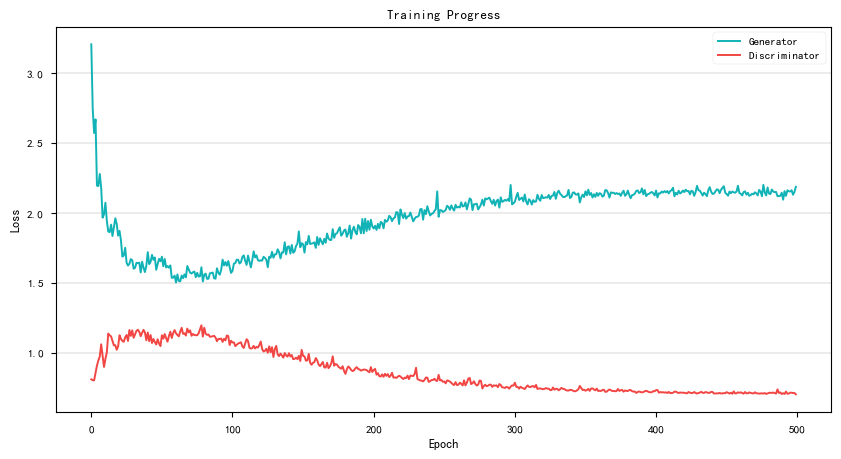

In [7]:
# 构造参数字典
params2 = {
    "train_args": {
        "generator_name": Generator,
        "discriminator_name": Discriminator,
        "data_loader": data_loader,
        "n_epochs": 500,
        "patience": 50,
        "learning_rate": 0.0002,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/DCGAN",
        "image_path": "../outputs/images",
        "device": 'cuda',
        "loss": nn.BCELoss(),
        "verbose": True,
        "plots": True,
        "clip_value": 0.1,
    },
    "generator_args": {
        'latent_dim': 32,
        'channels': 3,
    },
    "discriminator_args": {
        'channels': 3,
    },
}
generator = train(**params2)

### 图像生成